# Finale DataTour 2024 : Prédiction des ventes futures

## I. Set-up

### Installation & import des packages

In [ ]:
import os
import sys
sys.path.append(os.path.abspath("../"))

from src import config
from utils import eda_utils

# ignore warnings ;)
import warnings
warnings.simplefilter("ignore")

# set random seed for reproducibily
import numpy as np
np.random.seed(2024)

In [ ]:
%%capture
!pip install sklego optuna catboost xgboost lightgbm category_encoders

from datetime import datetime
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, HistGradientBoostingRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge, LogisticRegression, LinearRegression, QuantileRegressor, ElasticNet, Lasso

from sklego.linear_model import LADRegression
from category_encoders import TargetEncoder
from collections import Counter

from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor

#import optuna
import json

import warnings
warnings.filterwarnings('ignore')

In [ ]:
##Function to calculate regression metrics, evaluating accuracy
def regression_results(y_true, y_pred):
    # Regression metrics
    #mae = metrics.mean_absolute_error(y_true, y_pred)
    #mse = metrics.mean_squared_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    mape = metrics.mean_absolute_percentage_error(y_true, y_pred)

    print('r2: ', round(r2,4))
    #print('MAE: ', round(mae,4))
    #print('RMSE: ', round(np.sqrt(mse),4))
    print('MAPE: ', round(mape,4))

def _create_lag_features(df, column, window=3):
    for i in range(1, window+1):
        df[column + '_lag_' + str(i)] = df[column].shift(i)
    return df

def _create_rolling_features(df, column, window=3):
    for i in range(1, window+1):
        df[column + '_rolling_mean_' + str(i)] = df[column].shift(1).rolling(i).mean()
    return df

def _create_features(df):
    """
    Create time series features based on time series index and additional date-related features.
    """
    df = df.copy()

    # Existing features
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Additional features from the getDateFeature function
    #df['is_month_start'] = df.index.is_month_start.astype(int)
    #df['is_month_end'] = df.index.is_month_end.astype(int)
    df['is_quarter_start'] = df.index.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.index.is_quarter_end.astype(int)
    #df['is_year_start'] = df.index.is_year_start.astype(int)
    #df['is_year_end'] = df.index.is_year_end.astype(int)
    #df['is_leap_year'] = df.index.is_leap_year.astype(int)
    return df

def _add_season_flags(df):
    # Example for a generic African season classification
    conditions = [
        df['month'].isin([6, 7, 8, 9]),  # Rainy Season
        df['month'].isin([10, 11, 12, 1]),  # Dry Season
        df['month'].isin([2, 3, 4, 5])  # Transition Season (harmattan or cooler)
    ]
    choices = [0, 1, 2]
    df['season'] = np.select(conditions, choices, default='Unknown')
    df['season'] = df['season'].astype(int)
    return df

def _promotion_stock_ratio(df):
    df['promotion']=df['promotion']+1
    df['promotion_stock_ratio'] = np.log1p(df['stock_disponible']) / df['promotion']
    return df

# Function to parse 'id_produit'
def _extract_features_from_id_produit(df):
    # Split id_produit into components
    df[['cat_prefix', 'arrival_date', 'product_number']] = df['id_produit_raw'].str.split('-', expand=True)

    # Parse arrival month and year
    df['arrival_year'] = df['arrival_date'].str[-4:].astype(int)
    df['arrival_month'] = df['arrival_date'].str[:2].astype(int)

    # Create arrival datetime
    df['arrival_datetime'] = pd.to_datetime(
        df['arrival_year'].astype(str) + '-' + df['arrival_month'].astype(str) + '-01'
    )

    # Calculate elapsed days between arrival and sale date
    df['elapsed_days'] = (df.index - df['arrival_datetime']).dt.days

    # Convert product number to numeric
    df['product_number'] = df['product_number'].astype(int)

    # Drop intermediate columns if not needed
    df.drop(['cat_prefix', 'arrival_date', 'id_produit_raw', 'arrival_datetime'], axis=1, inplace=True)
    return df

def plot_histograms(df_train, df_test, target_col, n_cols=3):
    n_rows = (len(df_train.columns) - 1) // n_cols + 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
        #print(var_name)
        ax = axes[i]
        sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')      # plot train data

        if var_name != target_col:
            sns.distplot(df_test[var_name], kde=True, ax=ax, label='Submission')    # plot test data
        ax.set_title(f'{var_name} distribution')
        ax.legend()

    plt.tight_layout()
    plt.show()

def plot_categorical_distributions(df_train, df_test, cat_cols, n_cols=3):
    n_rows = (len(cat_cols) - 1) // n_cols + 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        ax = axes[i]

        # Distribution des catégories dans le train
        train_counts = df_train[col].value_counts(normalize=True).sort_index()
        test_counts = df_test[col].value_counts(normalize=True).sort_index()

        # Création des bar plots
        ax.bar(train_counts.index, train_counts.values, alpha=0.6, label='Train', color='blue')
        ax.bar(test_counts.index, test_counts.values, alpha=0.6, label='Submission', color='orange')

        ax.set_title(f'{col} Distribution')
        ax.set_xlabel(col)
        ax.set_ylabel('Proportion')
        ax.legend()

    # Ajuster les espacements
    plt.tight_layout()
    plt.show()

def plot_corr_matrix(train, submission, target, numeric_cols):
  corr_mat_df_all = train[numeric_cols + [target]].corr()
  corr_mat_submission = submission[numeric_cols].corr()

  df_all_mask = np.triu(np.ones_like(corr_mat_df_all, dtype = bool))
  submission_mask = np.triu(np.ones_like(corr_mat_submission, dtype = bool))

  cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)

  fig, axes = plt.subplots(1, 2, figsize = (25, 10))
  sns.heatmap(corr_mat_df_all, annot = True, cmap = cmap, fmt = '.2f', center = 0,
              annot_kws = {'size': 12}, ax = axes[0], mask = df_all_mask).set_title('Correlations Among Features (Training Dataset)')
  sns.heatmap(corr_mat_submission, annot = True, cmap = cmap, fmt = '.2f', center = 0,
              annot_kws = {'size': 12}, ax = axes[1], mask = submission_mask).set_title('Correlations Among Features (Submission Dataset)');

# Function to compare distributions for numerical columns
def compare_november_distributions(train_data, submission_data, cols, n_cols=3):
    n_rows = (len(cols) - 1) // n_cols + 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        ax = axes[i]
        sns.histplot(train_data[col], kde=True, ax=ax, label='Train - November', color='blue')
        sns.histplot(submission_data[col], kde=True, ax=ax, label='Submission - November', color='orange')
        ax.set_title(f'{col} Distribution')
        ax.legend()

    plt.tight_layout()
    plt.show()

### Importation des données

In [ ]:
train      = pd.read_csv('https://raw.githubusercontent.com/dataafriquehub/donnee_vente/refs/heads/main/train.csv', index_col=0)
submission = pd.read_csv('https://raw.githubusercontent.com/dataafriquehub/donnee_vente/refs/heads/main/submission.csv', index_col=0)

train      = train.set_index('date')
submission = submission.set_index('date')

train.index      = pd.to_datetime(train.index)
submission.index = pd.to_datetime(submission.index)

#train['date']       = train.index
#submission['date']  = submission.index

In [ ]:
display(train.index)
display(submission.index)

DatetimeIndex(['2022-01-01', '2022-01-01', '2022-01-01', '2022-01-01',
               '2022-01-01', '2022-01-01', '2022-01-01', '2022-01-01',
               '2022-01-01', '2022-01-01',
               ...
               '2024-10-31', '2024-10-31', '2024-10-31', '2024-10-31',
               '2024-10-31', '2024-10-31', '2024-10-31', '2024-10-31',
               '2024-10-31', '2024-10-31'],
              dtype='datetime64[ns]', name='date', length=83047, freq=None)

DatetimeIndex(['2024-11-01', '2024-11-01', '2024-11-01', '2024-11-01',
               '2024-11-01', '2024-11-01', '2024-11-01', '2024-11-01',
               '2024-11-01', '2024-11-01',
               ...
               '2024-11-30', '2024-11-30', '2024-11-30', '2024-11-30',
               '2024-11-30', '2024-11-30', '2024-11-30', '2024-11-30',
               '2024-11-30', '2024-11-30'],
              dtype='datetime64[ns]', name='date', length=2576, freq=None)

## II. Exploratory Data Analysis - EDA

### Basic exploration

In [ ]:
display(train.info())
display(submission.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83047 entries, 2022-01-01 to 2024-10-31
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_produit        71670 non-null  object 
 1   categorie         83047 non-null  object 
 2   marque            74704 non-null  object 
 3   prix_unitaire     78582 non-null  float64
 4   promotion         58923 non-null  float64
 5   jour_ferie        61982 non-null  float64
 6   weekend           64587 non-null  float64
 7   stock_disponible  68999 non-null  float64
 8   condition_meteo   72031 non-null  object 
 9   region            72382 non-null  object 
 10  moment_journee    66111 non-null  object 
 11  quantite_vendue   71640 non-null  float64
dtypes: float64(6), object(6)
memory usage: 8.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2576 entries, 2024-11-01 to 2024-11-30
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_produit        2576 non-null   object 
 1   categorie         2576 non-null   object 
 2   marque            2576 non-null   object 
 3   prix_unitaire     2576 non-null   float64
 4   promotion         2576 non-null   int64  
 5   jour_ferie        2576 non-null   int64  
 6   weekend           2576 non-null   int64  
 7   stock_disponible  2576 non-null   int64  
 8   condition_meteo   2576 non-null   object 
 9   region            2576 non-null   object 
 10  moment_journee    2576 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 241.5+ KB


None

In [ ]:
print("==="*25)
print(f"First few rows Training:\n")
display(train.head(3))
print("==="*25)
print(f"First few rows Submission:\n")
display(submission.head(3))
print("==="*25)
print(f"Shape of the data: \n\tTraining {train.shape}  \n\tSubmission {submission.shape} \n\n")
print("==="*25)

First few rows Training:



,id_produit,categorie,marque,prix_unitaire,promotion,jour_ferie,weekend,stock_disponible,condition_meteo,region,moment_journee,quantite_vendue
date,,,,,,,,,,,,
2022-01-01,HAB-102024-024,Habillement,Nike,31247.38,0.0,0.0,1.0,37.0,Neigeux,Urbain,Soirée,NaN
2022-01-01,ÉLE-062022-019,Électronique,Sony,13627.42,1.0,0.0,1.0,NaN,Ensoleillé,Urbain,Après-midi,23.0
2022-01-01,ALI-072022-019,Alimentaire,Nestlé,14606.88,1.0,0.0,1.0,426.0,Neigeux,Rural,Après-midi,7.0


First few rows Submission:



,id_produit,categorie,marque,prix_unitaire,promotion,jour_ferie,weekend,stock_disponible,condition_meteo,region,moment_journee
date,,,,,,,,,,,
2024-11-01,ALI-072024-023,Alimentaire,Coca-Cola,10692.72,1,0,0,168,Orageux,Urbain,Matinée
2024-11-01,ALI-042022-033,Alimentaire,Nestlé,30247.10,0,0,0,453,Neigeux,Urbain,Soirée
2024-11-01,HAB-102024-024,Habillement,Nike,24552.72,1,0,0,62,Ensoleillé,Périurbain,Soirée


Shape of the data: 
	Training (83047, 12)  
	Submission (2576, 11) 




In [ ]:
submission.groupby(['date', 'id_produit', 'categorie', 'marque'])['prix_unitaire'].mean().sort_values(ascending=False)[-5:]

,,,,prix_unitaire
date,id_produit,categorie,marque,
2024-11-04,ÉLE-032023-031,Électronique,Samsung,553.29
2024-11-20,HAB-032023-044,Habillement,Levi's,551.22
2024-11-13,HAB-072022-020,Habillement,Zara,548.03
2024-11-10,ALI-032022-042,Alimentaire,Kellogg's,513.78
2024-11-08,ÉLE-062024-039,Électronique,Sony,510.41


In [ ]:
train[train.index == '2022-02-01'][:50]

,id_produit,categorie,marque,prix_unitaire,promotion,jour_ferie,weekend,stock_disponible,condition_meteo,region,moment_journee,quantite_vendue
date,,,,,,,,,,,,
2022-02-01,HAB-042024-016,Habillement,Adidas,4992.50,0.0,NaN,0.0,132.0,Pluie,Périurbain,NaN,18.0
2022-02-01,ALI-062022-037,Alimentaire,Coca-Cola,2056.68,0.0,0.0,0.0,NaN,Pluie,NaN,Matinée,21.0
2022-02-01,ÉLE-102023-016,Électronique,Huawei,23628.72,NaN,0.0,0.0,190.0,Neigeux,NaN,Soirée,23.0
2022-02-01,HAB-102024-024,Habillement,Nike,29625.34,0.0,0.0,0.0,165.0,Ensoleillé,Rural,Après-midi,17.0
2022-02-01,HAB-042024-036,Habillement,Adidas,43531.79,0.0,0.0,0.0,81.0,Orageux,Périurbain,Après-midi,15.0
2022-02-01,HAB-052023-001,Habillement,Levi's,17165.26,0.0,0.0,0.0,95.0,Nuageux,Périurbain,Matinée,23.0
2022-02-01,HAB-112022-008,Habillement,H&M,NaN,NaN,0.0,NaN,385.0,NaN,Périurbain,Soirée,NaN
2022-02-01,ALI-042022-036,Alimentaire,Kellogg's,23094.06,1.0,0.0,0.0,374.0,Orageux,Périurbain,Matinée,23.0
2022-02-01,ÉLE-112022-015,Électronique,Sony,13002.45,1.0,NaN,0.0,307.0,Nuageux,Périurbain,Soirée,18.0


In [ ]:
"""for id in train.id_produit.unique():
  print(train.loc[train['id_produit'] == id, ['id_produit', 'categorie', 'marque', 'prix_unitaire']]) #.duplicated()
  print("==="*15)"""

'for id in train.id_produit.unique():\n  print(train.loc[train[\'id_produit\'] == id, [\'id_produit\', \'categorie\', \'marque\', \'prix_unitaire\']]) #.duplicated()\n  print("==="*15)'

In [ ]:
print("==="*25)
print(f"Number of duplicated values: \n\tTraining: {train.duplicated().sum()}  \n\tSubmission: {train.duplicated().sum()} \n\n")
print("==="*25)
print(f"Number of missing values by cols: \n\tTraining:\n{train.isna().sum().sort_values(ascending=False)}  \n\tSubmission:\n{submission.isna().sum().sort_values(ascending=False)} \n\n")
print("==="*25)

Number of duplicated values: 
	Training: 0  
	Submission: 0 


Number of missing values by cols: 
	Training:
promotion           24124
jour_ferie          21065
weekend             18460
moment_journee      16936
stock_disponible    14048
quantite_vendue     11407
id_produit          11377
condition_meteo     11016
region              10665
marque               8343
prix_unitaire        4465
categorie               0
dtype: int64  
	Submission:
id_produit          0
categorie           0
marque              0
prix_unitaire       0
promotion           0
jour_ferie          0
weekend             0
stock_disponible    0
condition_meteo     0
region              0
moment_journee      0
dtype: int64 




In [ ]:
#train.groupby('date')['categorie'].count().sort_values(ascending=False)[-15:]

In [ ]:
#train.groupby('promotion')['stock_disponible'].mean()

In [ ]:
#train.groupby('marque', 'id_produit')['quantite_vendue'].mean().sort_values(ascending=False)

In [ ]:
"""COLS = ['categorie', 'promotion', 'jour_ferie', 'weekend', 'moment_journee', 'condition_meteo', 'region', 'marque']
for col in COLS:
  print(train.groupby(col)['quantite_vendue'].mean())
  print("=="*30)"""

'COLS = [\'categorie\', \'promotion\', \'jour_ferie\', \'weekend\', \'moment_journee\', \'condition_meteo\', \'region\', \'marque\']\nfor col in COLS:\n  print(train.groupby(col)[\'quantite_vendue\'].mean())\n  print("=="*30)'

In [ ]:
#train['quantite_vendue'].value_counts(sort=True)

In [ ]:
#train['stock_disponible'].value_counts(sort=True) #[:10]

In [ ]:
# fonction to calculate univariate stats like pandas describe method
def univariate_stats(df):
    #df.drop('id', axis=1, inplace=True)
    output_df = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'IsNumeric', 'Mode', 'Mean', 'Min', '25%', 'Median', '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    for col in df:
        if is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], df[col].mean(), df[col].min(), df[col].quantile(.25), df[col].median(), df[col].quantile(.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurt() ]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], '-', '-', '-', '-', '-', '-', '-', '-', '-' ]
    return output_df.sort_values(by=['IsNumeric', 'Unique'], ascending=False)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)


# Call the function on train
display(univariate_stats(train))
display(univariate_stats(submission))

,Count,Missing,Unique,Dtype,IsNumeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
prix_unitaire,78582,4465,77956,float64,True,14206.7,25231.925162,501.46,12817.9975,25271.125,37569.77,49999.74,14290.966383,-0.001425,-1.200574
stock_disponible,68999,14048,501,float64,True,24.0,249.811041,0.0,123.0,250.0,376.0,500.0,145.028222,0.006762,-1.208286
quantite_vendue,71640,11407,39,float64,True,15.0,15.41971,1.0,12.0,15.0,18.0,39.0,4.651672,0.446604,0.278647
promotion,58923,24124,2,float64,True,1.0,0.500552,0.0,0.0,1.0,1.0,1.0,0.500004,-0.002206,-2.000063
jour_ferie,61982,21065,2,float64,True,0.0,0.018231,0.0,0.0,0.0,0.0,1.0,0.133787,7.20225,49.874017
weekend,64587,18460,2,float64,True,0.0,0.293,0.0,0.0,0.0,1.0,1.0,0.455142,0.909634,-1.172603
id_produit,71670,11377,150,object,False,ÉLE-092024-009,-,-,-,-,-,-,-,-,-
marque,74704,8343,15,object,False,Levi's,-,-,-,-,-,-,-,-,-
condition_meteo,72031,11016,5,object,False,Orageux,-,-,-,-,-,-,-,-,-
categorie,83047,0,3,object,False,Alimentaire,-,-,-,-,-,-,-,-,-


,Count,Missing,Unique,Dtype,IsNumeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
prix_unitaire,2576,0,2575,float64,True,36537.49,24468.487015,510.41,11626.3675,24553.84,36562.3125,49981.08,14406.705888,0.025883,-1.19692
stock_disponible,2576,0,499,int64,True,178,247.65295,0,124.0,239.0,375.0,500,144.572766,0.044014,-1.207611
promotion,2576,0,2,int64,True,1,0.503106,0,0.0,1.0,1.0,1,0.500087,-0.01243,-2.0014
weekend,2576,0,2,int64,True,0,0.260481,0,0.0,0.0,1.0,1,0.438982,1.092092,-0.807962
jour_ferie,2576,0,1,int64,True,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0
id_produit,2576,0,150,object,False,ALI-052024-018,-,-,-,-,-,-,-,-,-
marque,2576,0,15,object,False,Levi's,-,-,-,-,-,-,-,-,-
condition_meteo,2576,0,5,object,False,Nuageux,-,-,-,-,-,-,-,-,-
categorie,2576,0,3,object,False,Électronique,-,-,-,-,-,-,-,-,-
region,2576,0,3,object,False,Urbain,-,-,-,-,-,-,-,-,-


### Viz

In [ ]:
# List of numerical columns and categorical columns
target       = 'quantite_vendue'
categ_cols   = train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols.remove(target)

print(f"Colonnes numériques: {numeric_cols}")
print(f"Colonnes catégorielles: {categ_cols}")

Colonnes numériques: ['prix_unitaire', 'promotion', 'jour_ferie', 'weekend', 'stock_disponible']
Colonnes catégorielles: ['id_produit', 'categorie', 'marque', 'condition_meteo', 'region', 'moment_journee']


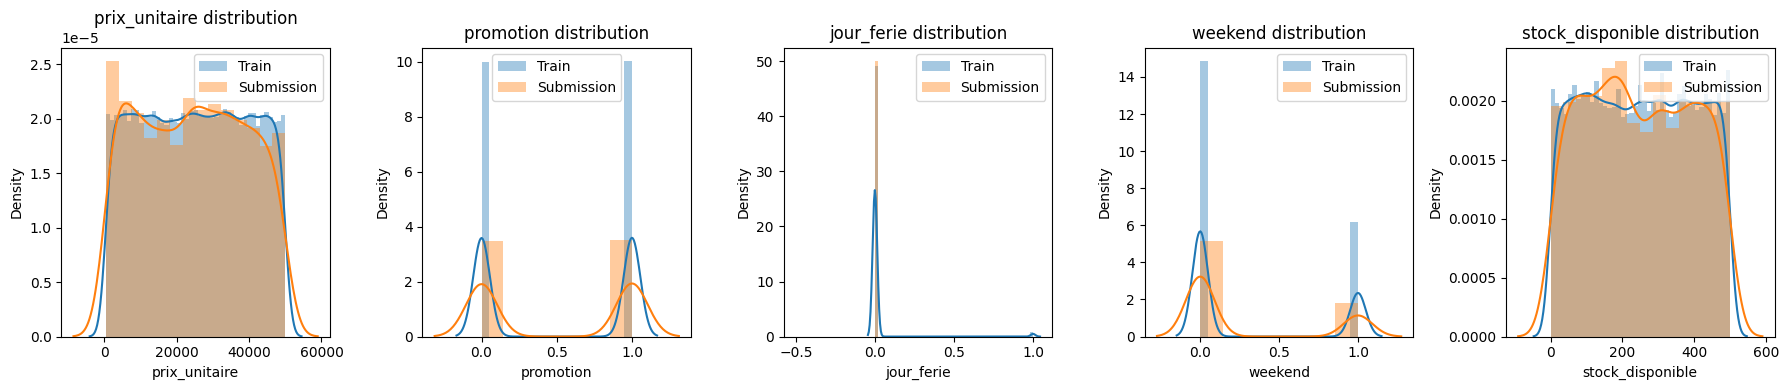

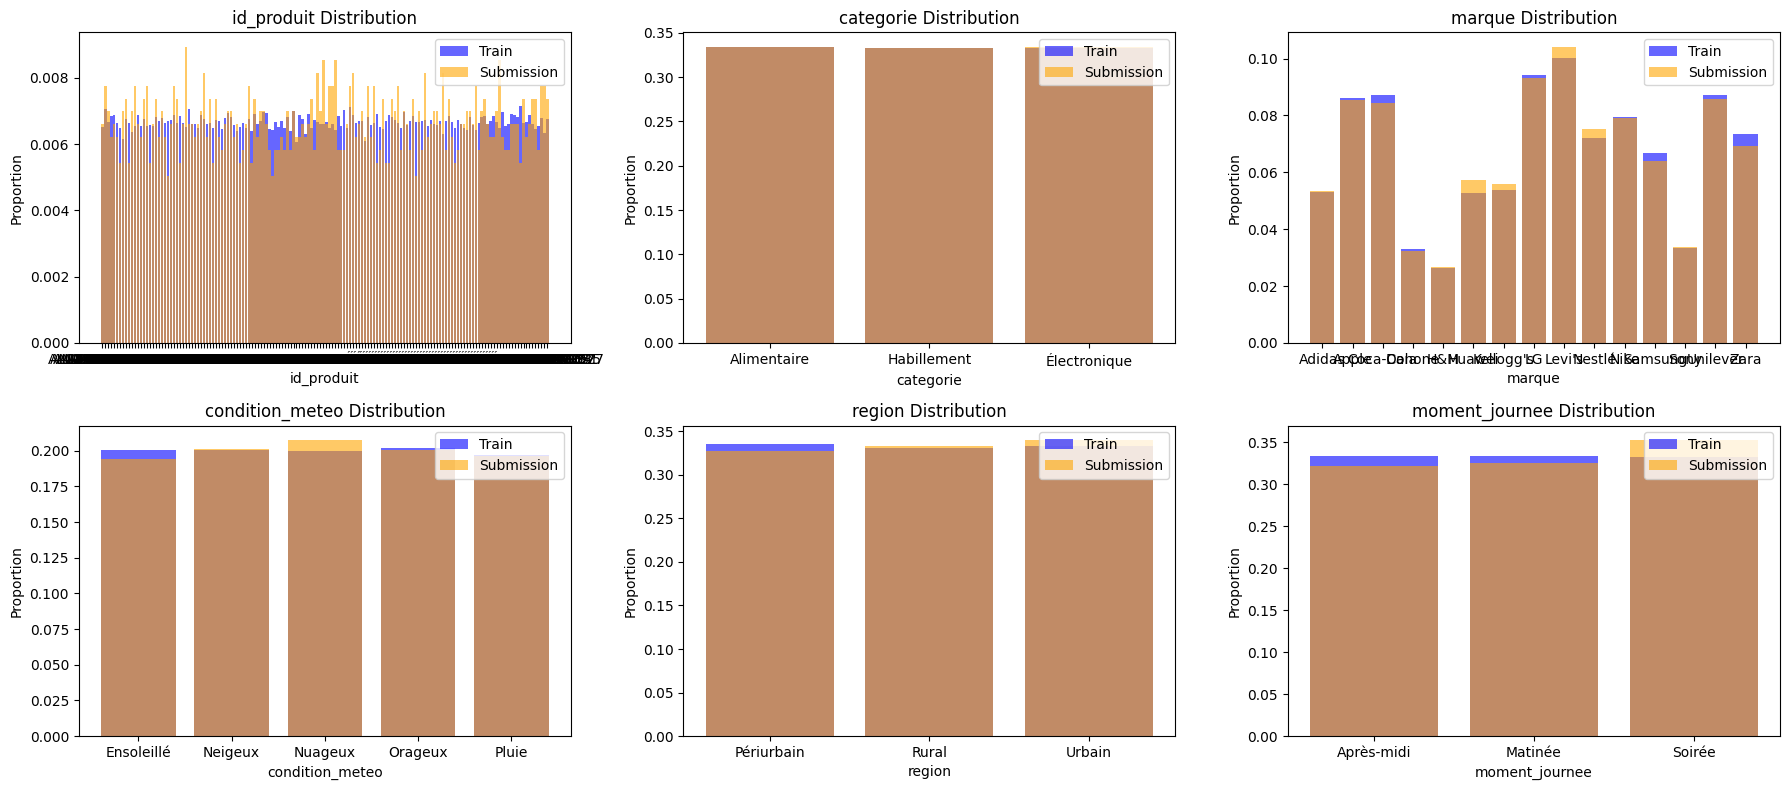

In [ ]:
plot_histograms(train[numeric_cols], submission[numeric_cols], target, n_cols=5)
plot_categorical_distributions(train, submission, categ_cols, n_cols=3)

In [ ]:
"""categorical_cols_to_display = train.select_dtypes(include=['object', 'int64']).columns.tolist()
for col in categorical_cols_to_display:
    print(f"Number of values in the {col} column is:\n{train[col].value_counts() }")
    print("==" * 30)"""

'categorical_cols_to_display = train.select_dtypes(include=[\'object\', \'int64\']).columns.tolist()\nfor col in categorical_cols_to_display:\n    print(f"Number of values in the {col} column is:\n{train[col].value_counts() }")\n    print("==" * 30)'

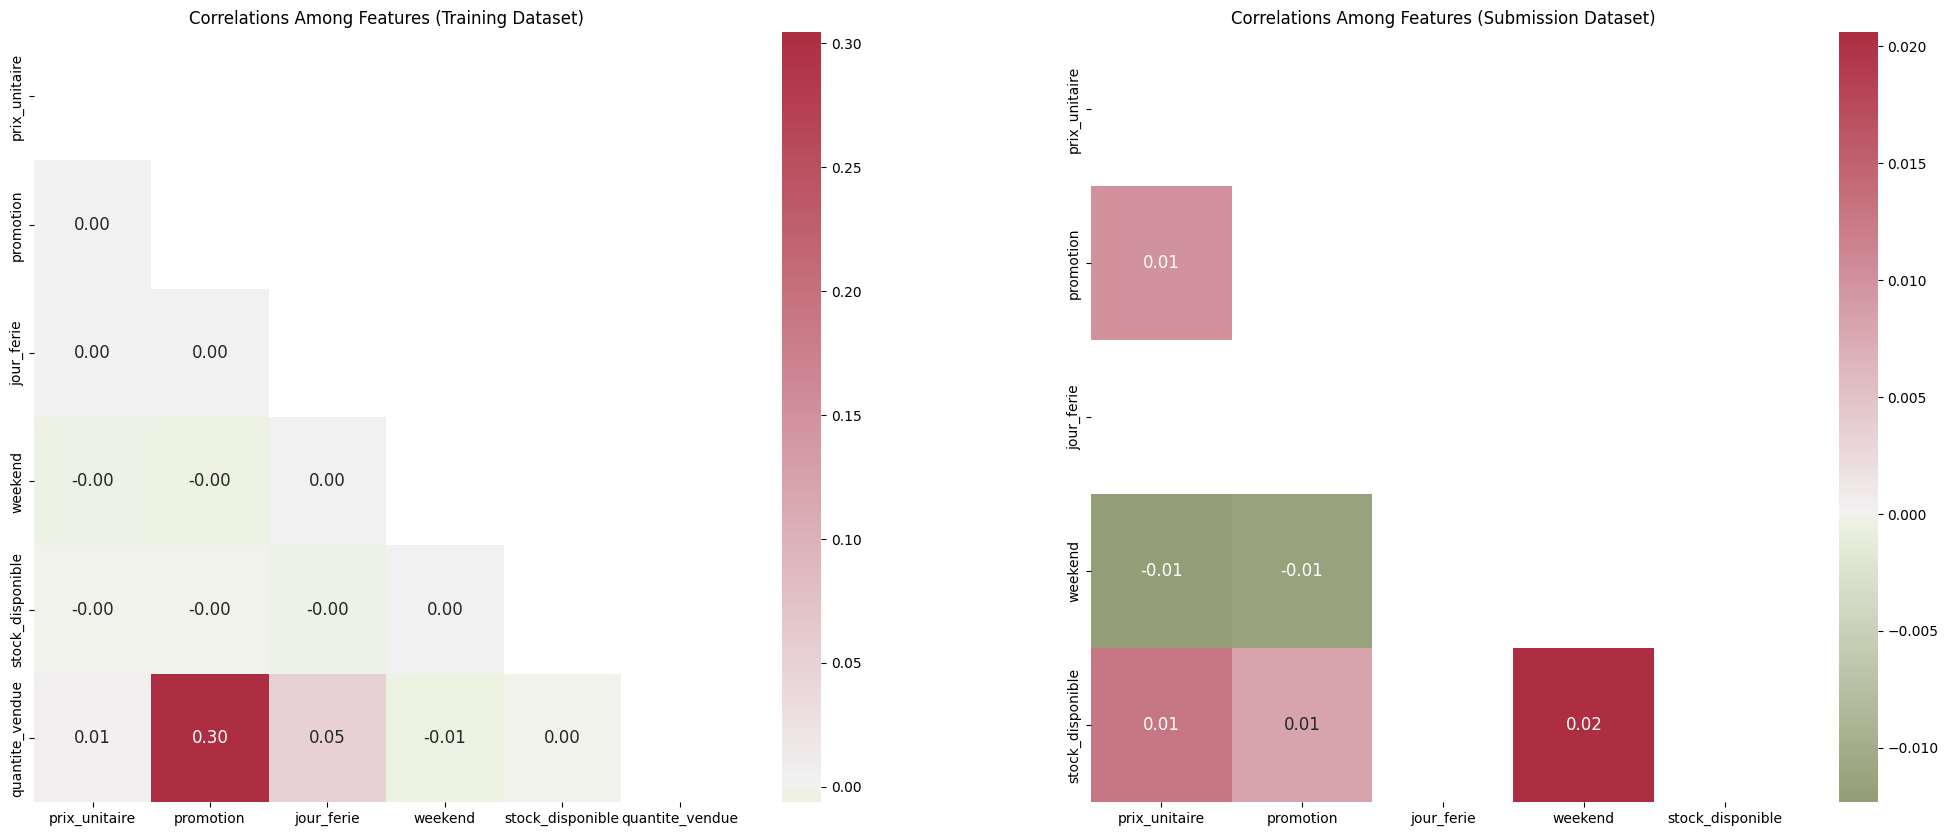

In [ ]:
plot_corr_matrix(train, submission, target, numeric_cols)

### Focus on november

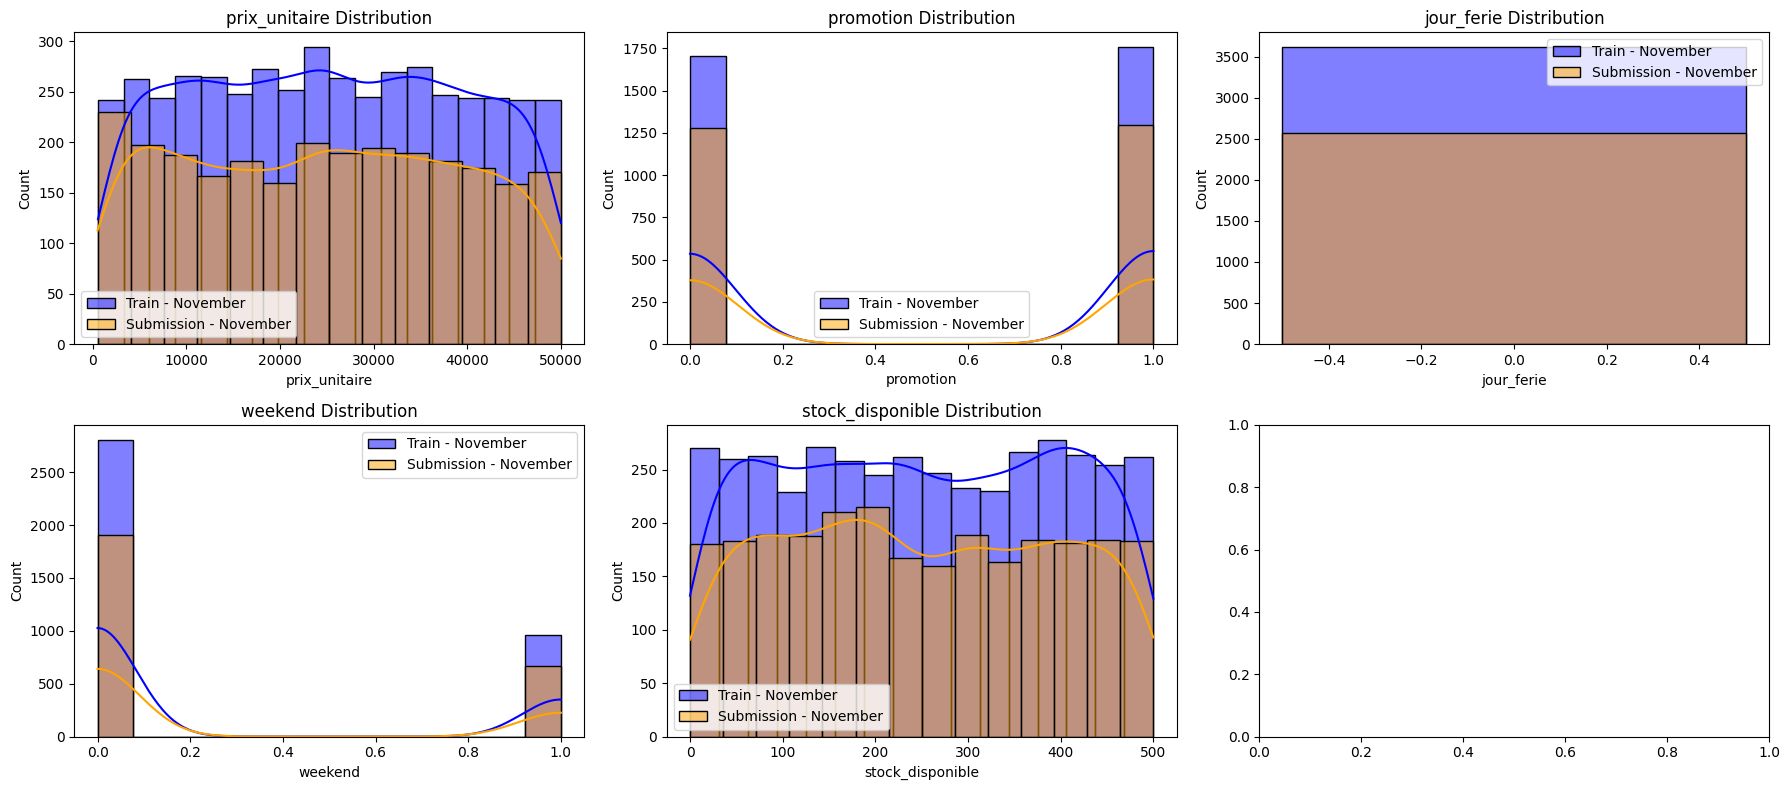

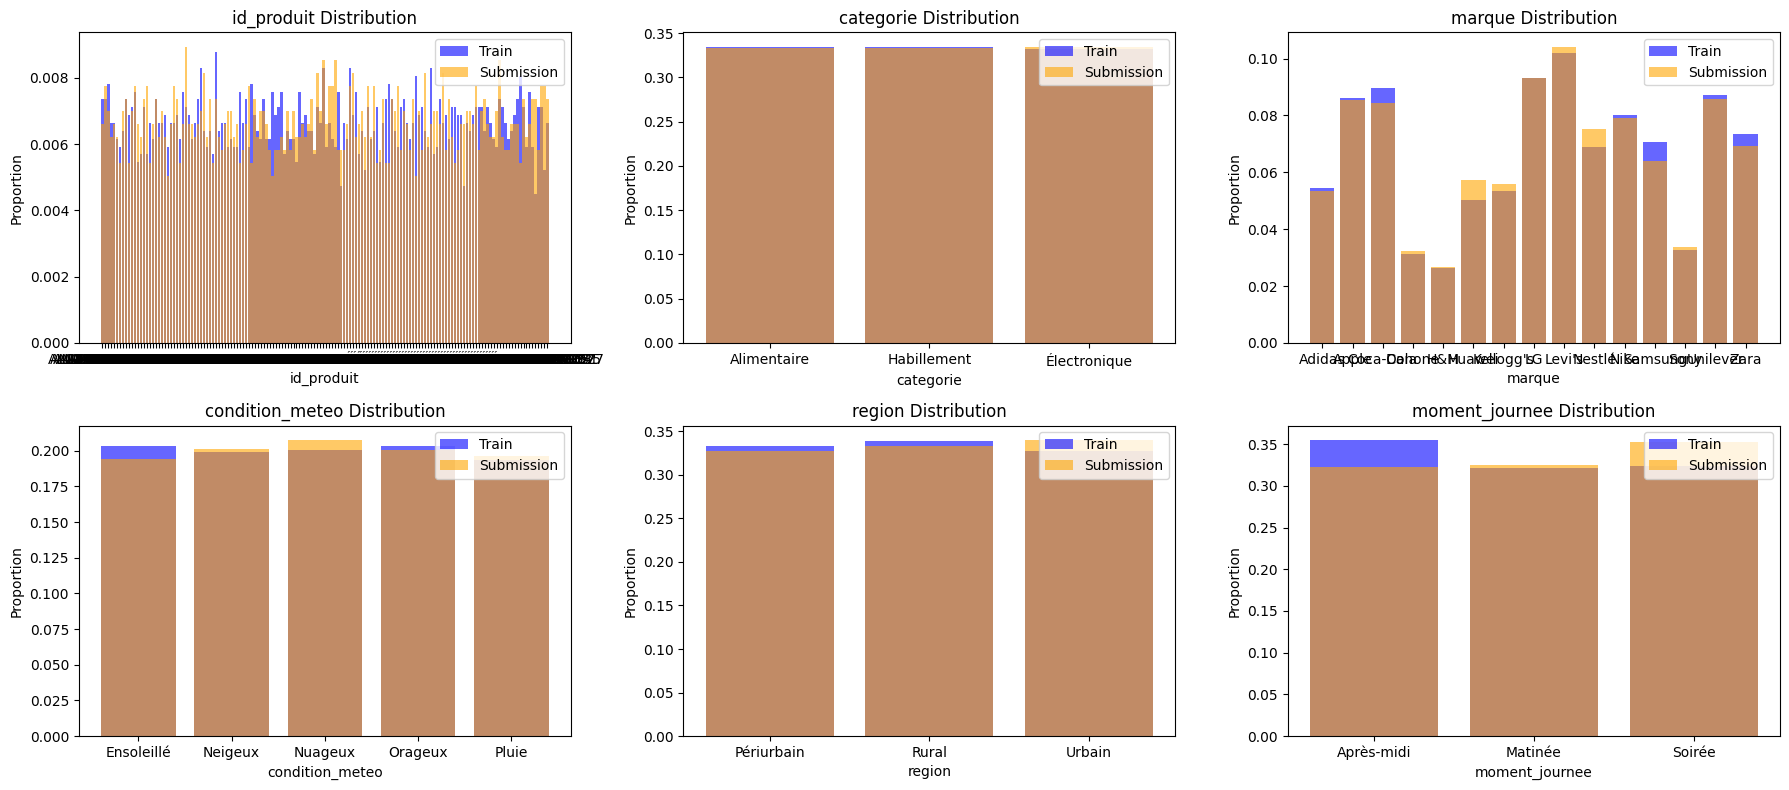

In [ ]:
# Filter train & submission data for November
train_november = train[train.index.month == 11]
submission_november = submission.copy()

compare_november_distributions(train_november, submission_november, numeric_cols)
plot_categorical_distributions(train_november, submission_november, categ_cols)

## III. Feature Engineering

In [ ]:
columns_to_drop = []
df_all     = train.drop(columns=columns_to_drop, axis=1)
submission = submission.drop(columns=columns_to_drop, axis=1)

df_all.shape, submission.shape

((83047, 12), (2576, 11))

In [ ]:
# flag rows with missing values
df_all['has_missing'] = df_all.isna().any(axis=1).astype(int)
submission['has_missing'] = submission.isna().any(axis=1).astype(int)
print(df_all[['has_missing']].value_counts())

has_missing
1              72124
0              10923
Name: count, dtype: int64


### Missing values treatment

##### 1- id_produit

Approche basée sur les fréquences

In [ ]:
# Step 1: Create a table of the most frequent 'id_produit' by 'categorie' and 'marque'
frequent_ids = (
    df_all.dropna(subset=['id_produit'])
    .groupby(['categorie', 'marque'])['id_produit']
    .agg(lambda x: x.value_counts().idxmax())  # Get most frequent 'id_produit' for each ('categorie', 'marque')
)

# Step 2: Create a table for the frequency of 'marque' by 'categorie'
marque_frequency_by_categorie = (
    df_all.dropna(subset=['marque'])
    .groupby(['categorie', 'marque'])['marque']
    .count()  # Count occurrences of 'marque' in each ('categorie', 'marque')
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
)

# Step 3: Define a function to fill missing 'id_produit' values
def fill_id(row):
    if pd.isna(row['id_produit']):  # Check if 'id_produit' is missing
        # Try to get the most frequent 'id_produit' for the given ('categorie', 'marque')
        key = (row['categorie'], row['marque'])
        if key in frequent_ids:
            return frequent_ids[key]

        # If there's no 'id_produit' for ('categorie', 'marque'), check the most frequent 'marque' in the 'categorie'
        # Resolve conflicts based on frequency of 'marque'
        most_frequent_marque = marque_frequency_by_categorie.loc[marque_frequency_by_categorie['categorie'] == row['categorie']].iloc[0]['marque']

        # Use the most frequent 'id_produit' for the most frequent 'marque' in that 'categorie'
        return frequent_ids.get((row['categorie'], most_frequent_marque), None)

    return row['id_produit']  # Keep original value if not missing

# Step 4: Apply the function row-wise
df_all['id_produit'] = df_all.apply(fill_id, axis=1)
print(f"Nombre de valeurs manquantes dans 'id_produit' après traitement: {df_all['id_produit'].isna().sum()}")

Nombre de valeurs manquantes dans 'id_produit' après traitement: 0


#### 2- marque

In [ ]:
"""# Step 1: Create tables of most frequent 'marque'
# First group by 'categorie' and 'id_produit' to get the most frequent 'marque'
frequent_marque_by_id = (
    df_all.dropna(subset=['marque'])  # Remove rows where 'marque' is missing
    .groupby(['categorie', 'id_produit'])['marque']
    .agg(lambda x: x.value_counts().idxmax())  # Get most frequent 'marque'
)

# Then group by 'categorie' alone as a fallback
frequent_marque_by_categorie = (
    df_all.dropna(subset=['marque'])
    .groupby(['categorie'])['marque']
    .agg(lambda x: x.value_counts().idxmax())  # Most frequent 'marque' per 'categorie'
)

# Step 2: Define the function to impute missing values
def fill_marque(row):
    if pd.isna(row['marque']):  # Check if 'marque' is missing
        # Try to get the most frequent 'marque' for the given 'categorie' and 'id_produit'
        key = (row['categorie'], row['id_produit'])
        if key in frequent_marque_by_id:
            return frequent_marque_by_id[key]
        # Fallback: Get the most frequent 'marque' for the 'categorie'
        return frequent_marque_by_categorie.get(row['categorie'], None)
    return row['marque']  # Keep the original value if not missing

# Step 3: Apply the function row-wise to fill missing 'marque'
df_all['marque'] = df_all.apply(fill_marque, axis=1)
print(f"Nombre de valeurs manquantes dans 'marque' après traitement: {df_all['marque'].isna().sum()}")"""

'# Step 1: Create tables of most frequent \'marque\'\n# First group by \'categorie\' and \'id_produit\' to get the most frequent \'marque\'\nfrequent_marque_by_id = (\n    df_all.dropna(subset=[\'marque\'])  # Remove rows where \'marque\' is missing\n    .groupby([\'categorie\', \'id_produit\'])[\'marque\']\n    .agg(lambda x: x.value_counts().idxmax())  # Get most frequent \'marque\'\n)\n\n# Then group by \'categorie\' alone as a fallback\nfrequent_marque_by_categorie = (\n    df_all.dropna(subset=[\'marque\'])\n    .groupby([\'categorie\'])[\'marque\']\n    .agg(lambda x: x.value_counts().idxmax())  # Most frequent \'marque\' per \'categorie\'\n)\n\n# Step 2: Define the function to impute missing values\ndef fill_marque(row):\n    if pd.isna(row[\'marque\']):  # Check if \'marque\' is missing\n        # Try to get the most frequent \'marque\' for the given \'categorie\' and \'id_produit\'\n        key = (row[\'categorie\'], row[\'id_produit\'])\n        if key in frequent_marque_by_i

#### 3- weekend

In [ ]:
def fix_weekend_column(df):
    df['weekend'] = df['weekend'].fillna(
      (df.index.to_series().dt.weekday >= 5).astype(int)
    )
    return df

df_all = fix_weekend_column(df_all)

#### 4- jour_ferie

In [ ]:
def verify_and_impute_jour_ferie(df):
    # Vérification des valeurs non manquantes
    non_missing = df[~df['jour_ferie'].isna()]
    incorrect_rows = non_missing[(non_missing['jour_ferie'] == 1) & (non_missing.index.month != 12)]

    if not incorrect_rows.empty:
        print("Assomption non vérifiée. Voici les lignes où 'jour_ferie' = 1 en dehors de décembre:")
        print(incorrect_rows)
        return df  # Retourne le DataFrame d'origine si l'assomption est fausse

    print("Assomption vérifiée: 'jour_ferie' = 1 uniquement en décembre pour les valeurs non manquantes.")

    is_december = (df.index.month == 12) # Créer une série booléenne pour les mois de décembre

    missing_indices = df['jour_ferie'].isna()
    df.loc[missing_indices, 'jour_ferie'] = is_december[missing_indices].astype(float) # Imputation des valeurs manquantes

    return df

df_all['jour_ferie'] = df_all['jour_ferie'].astype(float)  # S'assurer du type float si nécessaire
df_all = verify_and_impute_jour_ferie(df_all)
print(f"Valeurs manquantes dans 'jour_ferie': {df_all['jour_ferie'].isna().sum()}")

Assomption vérifiée: 'jour_ferie' = 1 uniquement en décembre pour les valeurs non manquantes.
Valeurs manquantes dans 'jour_ferie': 0


#### 4. approche générale

In [ ]:
"""def impute_missing_values(df, column_features_map):
    df_imputed = df.copy()  # Copie pour ne pas modifier l'original

    for target_column, feature_columns in column_features_map.items():
        print(f"Imputation de la colonne: {target_column}")

        # Séparer les lignes avec et sans valeurs manquantes
        train_data = df_imputed.dropna(subset=[target_column])
        missing_data = df_imputed[df_imputed[target_column].isna()]

        # Si aucune valeur manquante, passer
        if missing_data.empty:
            print(f"Aucune valeur manquante pour {target_column}.")
            continue

        # Créer les variables X et y
        X_train = train_data[feature_columns]
        y_train = train_data[target_column]
        X_missing = missing_data[feature_columns]

        # Encodage des colonnes catégoriques
        label_encoders = {}
        for col in X_train.select_dtypes(include=['object']).columns:
            le = LabelEncoder()
            X_train[col] = le.fit_transform(X_train[col])
            X_missing[col] = X_missing[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1).fillna(-1)
            label_encoders[col] = le

        # Encoder la colonne cible si elle est catégorique
        if y_train.dtype == 'object':
            target_encoder = LabelEncoder()
            y_train = target_encoder.fit_transform(y_train)
            is_categorical = True
        else:
            is_categorical = False

        # Compléter les colonnes manquantes pour aligner X_train et X_missing
        X_missing = pd.get_dummies(X_missing, dummy_na=True)
        X_train = pd.get_dummies(X_train, dummy_na=True)
        X_missing = X_missing.reindex(columns=X_train.columns, fill_value=0)

        # Choisir le modèle approprié
        model = RandomForestClassifier(random_state=2024) if is_categorical else RandomForestRegressor(random_state=2024)

        # Entraîner le modèle
        model.fit(X_train, y_train)

        # Effectuer les prédictions
        predictions = model.predict(X_missing)

        # Décoder si nécessaire
        if is_categorical:
            predictions = target_encoder.inverse_transform(predictions)

        # Remplacer les valeurs manquantes dans la colonne cible
        df_imputed.loc[df_imputed[target_column].isna(), target_column] = predictions

    return df_imputed


column_features_map = {
    #'id_produit': ['categorie', 'marque', 'prix_unitaire'],
    #'promotion': ['id_produit', 'categorie', 'marque', 'prix_unitaire', 'region', 'condition_meteo', 'jour_ferie'],
    #'moment_journee': ['id_produit', 'categorie', 'marque', 'condition_meteo', 'region', 'prix_unitaire', 'jour_ferie'],
    #'stock_disponible': ['id_produit', 'promotion', 'jour_ferie', 'categorie', 'marque', 'region'],
    #'condition_meteo': ['id_produit', 'region', 'moment_journee', 'stock_disponible', 'jour_ferie'],
    #'region': ['id_produit', 'categorie', 'marque', 'condition_meteo', 'prix_unitaire', 'jour_ferie'],
    #'marque': ['id_produit', 'categorie', 'prix_unitaire', 'region', 'promotion', 'jour_ferie'],
    #'prix_unitaire': ['id_produit', 'categorie', 'marque', 'region', 'condition_meteo', 'jour_ferie'],
}

# Exécuter l'imputation
#df_all = impute_missing_values(df_all, column_features_map)
#df_all = df_all.dropna(subset=['quantite_vendue'])

# Vérification des valeurs manquantes restantes
print(f"Valeurs manquantes restantes: \n{df_all.isna().sum()}")"""

'def impute_missing_values(df, column_features_map):\n    df_imputed = df.copy()  # Copie pour ne pas modifier l\'original\n\n    for target_column, feature_columns in column_features_map.items():\n        print(f"Imputation de la colonne: {target_column}")\n\n        # Séparer les lignes avec et sans valeurs manquantes\n        train_data = df_imputed.dropna(subset=[target_column])\n        missing_data = df_imputed[df_imputed[target_column].isna()]\n\n        # Si aucune valeur manquante, passer\n        if missing_data.empty:\n            print(f"Aucune valeur manquante pour {target_column}.")\n            continue\n\n        # Créer les variables X et y\n        X_train = train_data[feature_columns]\n        y_train = train_data[target_column]\n        X_missing = missing_data[feature_columns]\n\n        # Encodage des colonnes catégoriques\n        label_encoders = {}\n        for col in X_train.select_dtypes(include=[\'object\']).columns:\n            le = LabelEncoder()\n       

In [ ]:
def fillNaFeaturesRelatedToIdProduit(X_train, X_test):
    train_id_produit = X_train['id_produit']
    test_id_produit = X_test['id_produit']

    # Fill 'id_produit' NaNs with corresponding 'categorie' values
    X_train['id_produit'] = X_train['id_produit'].fillna(X_train['categorie'])
    X_test['id_produit'] = X_test['id_produit'].fillna(X_test['categorie'])

    # Fill 'prix_unitaire' based on 'id_produit' group in training set
    train_grouped_means = X_train.groupby('id_produit')['prix_unitaire'].mean()
    X_train['prix_unitaire'] = X_train.apply(
        lambda row: train_grouped_means[row['id_produit']] if pd.isna(row['prix_unitaire']) else row['prix_unitaire'],
        axis=1
    )
    X_test['prix_unitaire'] = X_test.apply(
        lambda row: train_grouped_means[row['id_produit']] if pd.isna(row['prix_unitaire']) else row['prix_unitaire'],
        axis=1
    )

    # Fill 'marque' based on 'id_produit' group in training set
    train_grouped_modes = X_train.groupby('id_produit')['marque'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown')
    X_train['marque'] = X_train.apply(
        lambda row: train_grouped_modes[row['id_produit']] if pd.isna(row['marque']) else row['marque'],
        axis=1
    )
    X_test['marque'] = X_test.apply(
        lambda row: train_grouped_modes[row['id_produit']] if pd.isna(row['marque']) else row['marque'],
        axis=1
    )

    # Fill 'stock_disponible' based on 'id_produit' group in training set
    train_grouped_stock_means = X_train.groupby('id_produit')['stock_disponible'].mean()
    X_train['stock_disponible'] = X_train.apply(
        lambda row: train_grouped_stock_means[row['id_produit']] if pd.isna(row['stock_disponible']) else row['stock_disponible'],
        axis=1
    )
    X_test['stock_disponible'] = X_test.apply(
        lambda row: train_grouped_stock_means[row['id_produit']] if pd.isna(row['stock_disponible']) else row['stock_disponible'],
        axis=1
    )
    X_train['id_produit'] = train_id_produit
    X_test['id_produit'] = test_id_produit

    return X_train, X_test

df_all, submission = fillNaFeaturesRelatedToIdProduit(df_all, submission)

In [ ]:
#df_all = df_all.dropna(subset=['quantite_vendue'])
df_all['region'] = df_all['region'].fillna('NONE')
df_all['condition_meteo'] = df_all.groupby(['region', 'moment_journee'])['condition_meteo'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'NONE'))
df_all['moment_journee'] = df_all['moment_journee'].fillna('NONE')


for col in ['marque', 'condition_meteo', 'region', 'moment_journee', 'id_produit']:
    df_all[col] = df_all[col].fillna(df_all[col].mode()[0])
    submission[col] = submission[col].fillna(submission[col].mode()[0])

print(f"Total Number of missing values: \nTraining: {df_all.isna().sum().sum()}  \nSubmission: {submission.isna().sum().sum()} \n\n")

Total Number of missing values: 
Training: 35531  
Submission: 0 




In [ ]:
"""df_all = df_all.dropna(subset=['quantite_vendue'])
df_all['region'] = df_all['region'].fillna('NONE')
df_all['condition_meteo'] = df_all.groupby('region')['condition_meteo'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'NONE'))
df_all['moment_journee'] = df_all['moment_journee'].fillna('NONE')


for col in ['id_produit',
            'marque',
            'condition_meteo',
            'region',
            'moment_journee',
            #'promotion',
            'prix_unitaire',
            'stock_disponible'
            ]:
    df_all[col] = df_all[col].fillna(df_all[col].mode()[0])
    submission[col] = submission[col].fillna(submission[col].mode()[0])

print(f"Total Number of missing values: \nTraining: {df_all.isna().sum().sum()}  \nSubmission: {submission.isna().sum().sum()} \n\n")"""

'df_all = df_all.dropna(subset=[\'quantite_vendue\'])\ndf_all[\'region\'] = df_all[\'region\'].fillna(\'NONE\')\ndf_all[\'condition_meteo\'] = df_all.groupby(\'region\')[\'condition_meteo\'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else \'NONE\'))\ndf_all[\'moment_journee\'] = df_all[\'moment_journee\'].fillna(\'NONE\')\n\n\nfor col in [\'id_produit\',\n            \'marque\',\n            \'condition_meteo\',\n            \'region\',\n            \'moment_journee\',\n            #\'promotion\',\n            \'prix_unitaire\',\n            \'stock_disponible\'\n            ]:\n    df_all[col] = df_all[col].fillna(df_all[col].mode()[0])\n    submission[col] = submission[col].fillna(submission[col].mode()[0])\n\nprint(f"Total Number of missing values: \nTraining: {df_all.isna().sum().sum()}  \nSubmission: {submission.isna().sum().sum()} \n\n")'

In [ ]:
print(f"Valeurs manquantes restantes: \n{df_all.isna().sum()}")

Valeurs manquantes restantes: 
id_produit              0
categorie               0
marque                  0
prix_unitaire           0
promotion           24124
jour_ferie              0
weekend                 0
stock_disponible        0
condition_meteo         0
region                  0
moment_journee          0
quantite_vendue     11407
has_missing             0
dtype: int64


In [ ]:
"""COLS_INT = ['stock_disponible',
            #'promotion',
            'jour_ferie',
            'weekend',
            'quantite_vendue']
for col in COLS_INT:
    df_all[col] = df_all[col].astype(int)
#df_all.info()"""

"COLS_INT = ['stock_disponible',\n            #'promotion',\n            'jour_ferie',\n            'weekend',\n            'quantite_vendue']\nfor col in COLS_INT:\n    df_all[col] = df_all[col].astype(int)\n#df_all.info()"

In [ ]:
#stop

### Encoding

In [ ]:
df_all['id_produit_raw'] = df_all['id_produit']
submission['id_produit_raw'] = submission['id_produit']

for col in categ_cols:
    print(f"Encoding column {col}")
    # initialize LabelEncoder for each feature column
    lbl = LabelEncoder()

    # fit label encoder on all data
    lbl.fit(df_all[col])

    # transform all the data
    df_all.loc[:, col]         = lbl.transform(df_all[col]) #.astype(int)
    submission.loc[:, col]     = lbl.transform(submission[col]) #.astype(int)

for col in categ_cols:
    df_all[col] = df_all[col].astype(int)
    submission[col] = submission[col].astype(int)

print(f"""shape: {df_all.shape}\n""")
print("===="*15)

df_all.head(3)

Encoding column id_produit
Encoding column categorie
Encoding column marque
Encoding column condition_meteo
Encoding column region
Encoding column moment_journee
shape: (83047, 14)



,id_produit,categorie,marque,prix_unitaire,promotion,jour_ferie,weekend,stock_disponible,condition_meteo,region,moment_journee,quantite_vendue,has_missing,id_produit_raw
date,,,,,,,,,,,,,,
2022-01-01,93,1,10,31247.38,0.0,0.0,1.0,37.000000,1,3,3,NaN,1,HAB-102024-024
2022-01-01,122,2,12,13627.42,1.0,0.0,1.0,260.183784,0,3,0,23.0,1,ÉLE-062022-019
2022-01-01,34,0,9,14606.88,1.0,0.0,1.0,426.000000,1,2,0,7.0,0,ALI-072022-019


In [ ]:
"""# GUYSSSSS PAY ATTENTION TO THIS CELL
# I wanted to keep missing values to try XGBoost ability to handle them

df_all_xgb = df_all.copy()
submission_xgb = submission.copy()"""

'# GUYSSSSS PAY ATTENTION TO THIS CELL\n# I wanted to keep missing values to try XGBoost ability to handle them\n\ndf_all_xgb = df_all.copy()\nsubmission_xgb = submission.copy()'

In [ ]:
"""# THIS CELL TOOOOOOOOO, it made the DIFFERENCE AS I TRIED TO FIND THE BEST VALUE OF n_neighbors
# HOPE I DIN'T OVERFITTT TOO MUCHHHHH hhhhhh

imputer = KNNImputer(n_neighbors=6)

df_all = pd.DataFrame(imputer.fit_transform(df_all), columns = df_all.columns)
display(df_all.head(3))

print(f"Total Number of missing values: \nTraining: {df_all.isna().sum().sum()}  \nSubmission: {submission.isna().sum().sum()} \n\n")
"""

'# THIS CELL TOOOOOOOOO, it made the DIFFERENCE AS I TRIED TO FIND THE BEST VALUE OF n_neighbors\n# HOPE I DIN\'T OVERFITTT TOO MUCHHHHH hhhhhh\n\nimputer = KNNImputer(n_neighbors=6)\n\ndf_all = pd.DataFrame(imputer.fit_transform(df_all), columns = df_all.columns)\ndisplay(df_all.head(3))\n\nprint(f"Total Number of missing values: \nTraining: {df_all.isna().sum().sum()}  \nSubmission: {submission.isna().sum().sum()} \n\n")\n'

### Engineering

In [ ]:
# Function to add new features to the dataset
def feature_engineering(df):
    # Adding brand new features
    #df = _create_lag_features(df, 'quantite_vendue', window=3)
    #df = _create_rolling_features(df, 'quantite_vendue', window=3)
    df = _create_features(df)
    df = _add_season_flags(df)
    #df = _promotion_stock_ratio(df)
    df = _extract_features_from_id_produit(df)

    return df #, new_cols

In [ ]:
df_all_prep     = feature_engineering(df_all)
submission_prep = feature_engineering(submission)
display(submission_prep.head())
df_all_prep.shape, submission_prep.shape

,id_produit,categorie,marque,prix_unitaire,promotion,jour_ferie,weekend,stock_disponible,condition_meteo,region,moment_journee,has_missing,day,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_quarter_start,is_quarter_end,season,product_number,arrival_year,arrival_month,elapsed_days
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-01,38,0,2,10692.72,1,0,0,168,3,3,1,0,1,4,4,11,2024,306,1,44,0,0,1,23,2024,7,123
2024-11-01,14,0,9,30247.10,0,0,0,453,1,3,3,0,1,4,4,11,2024,306,1,44,0,0,1,33,2022,4,945
2024-11-01,93,1,10,24552.72,1,0,0,62,0,1,3,0,1,4,4,11,2024,306,1,44,0,0,1,24,2024,10,31
2024-11-01,34,0,9,23933.82,0,0,0,21,4,3,0,0,1,4,4,11,2024,306,1,44,0,0,1,19,2022,7,854
2024-11-01,15,0,6,925.47,1,0,0,114,2,3,0,0,1,4,4,11,2024,306,1,44,0,0,1,36,2022,4,945


((83047, 28), (2576, 27))

In [ ]:
set(df_all_prep.columns) - set(submission_prep.columns)

{'quantite_vendue'}

In [ ]:
# Map each category to its frequency value
#df_all_prep['categorie_freq'] = df_all_prep['categorie'].map(df_all_prep['categorie'].value_counts())

# Apply frequency encoding to the 'categorie' column in submission_df
#submission_prep['categorie_freq'] = submission_prep['categorie'].map(df_all_prep['categorie'].value_counts())

In [ ]:
# Step 1: Identify rows with known and unknown promotions
df_all_prep.reset_index(drop=True, inplace=True)

known_promotion   = df_all_prep[df_all_prep['promotion'].notna()]
unknown_promotion = df_all_prep[df_all_prep['promotion'].isna()]


# Keep the original indices
unknown_indices = unknown_promotion.index

X_known = known_promotion.drop(['promotion','id_produit'], axis=1)
y_known = known_promotion['promotion']

X_unknown = unknown_promotion.drop(['promotion','id_produit'], axis=1)

# Step 4: Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_known, y_known)

# Step 5: Predict missing promotion values
predicted_promotion = model.predict(X_unknown)

# Step 6: Insert predictions back into the original dataset
df_all_prep.loc[unknown_indices, 'promotion'] = predicted_promotion

In [ ]:
df_all_prep.shape, submission_prep.shape

((83047, 28), (2576, 27))

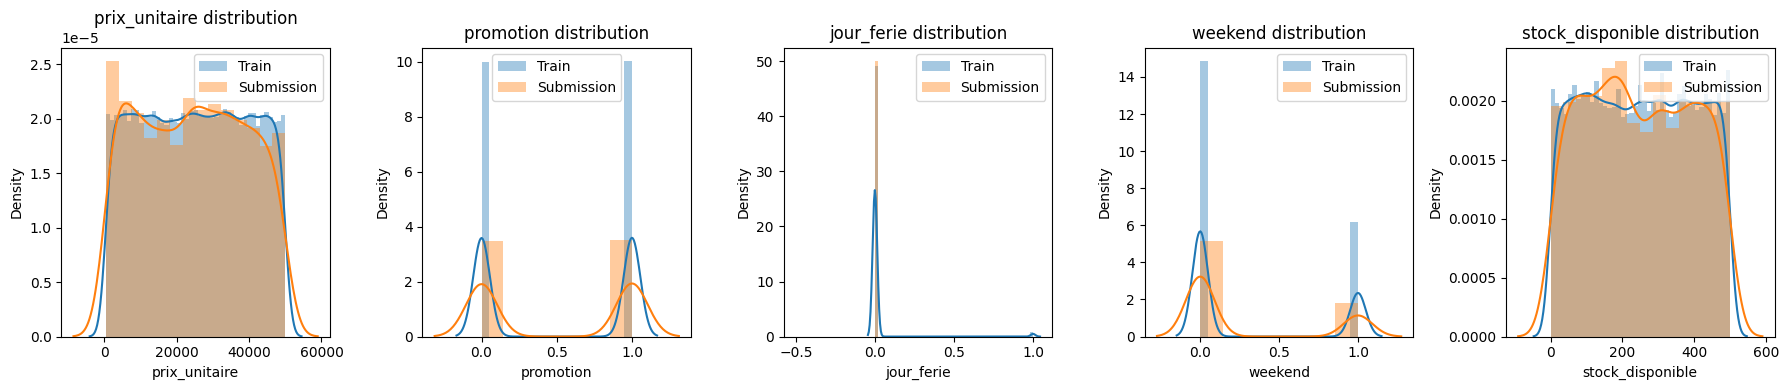

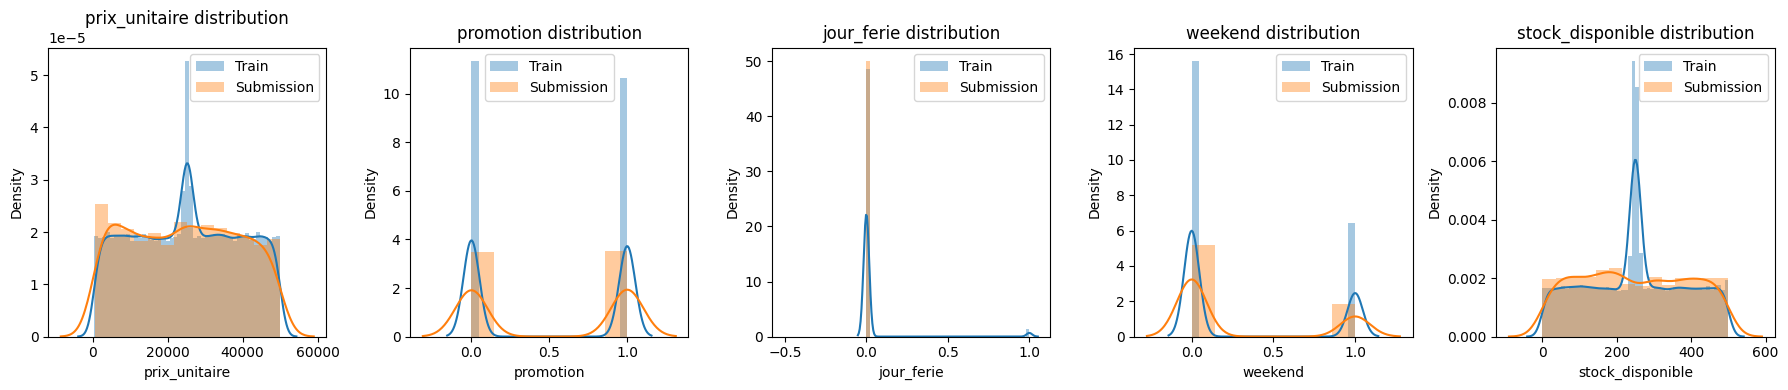

In [ ]:
plot_histograms(train[numeric_cols], submission[numeric_cols], target, n_cols=5)
plot_histograms(df_all_prep[numeric_cols], submission_prep[numeric_cols], target, n_cols=5)

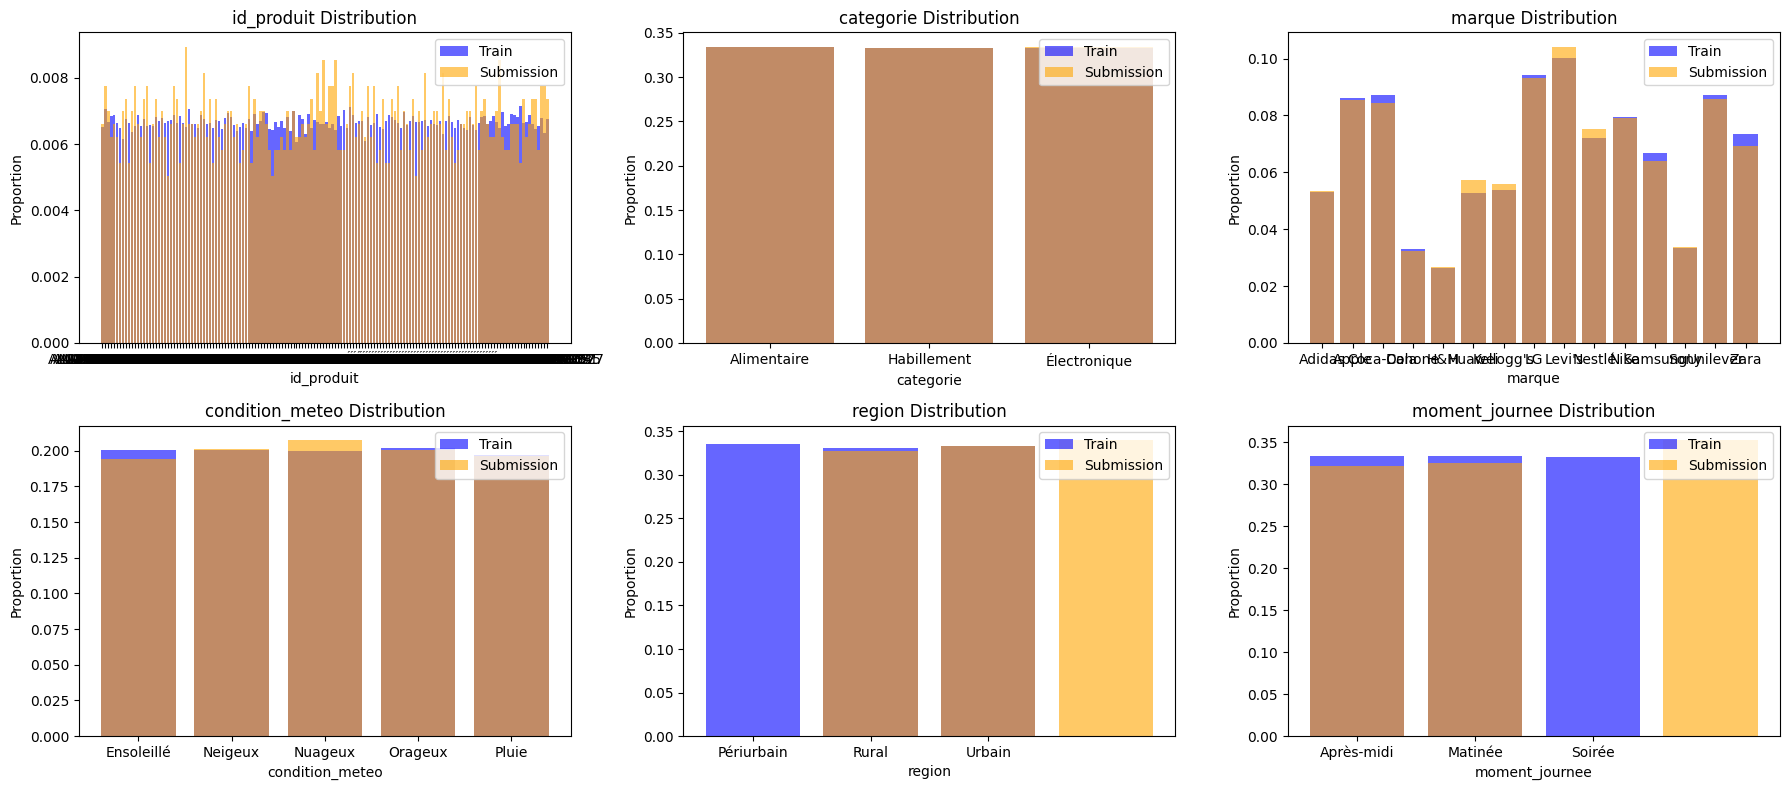

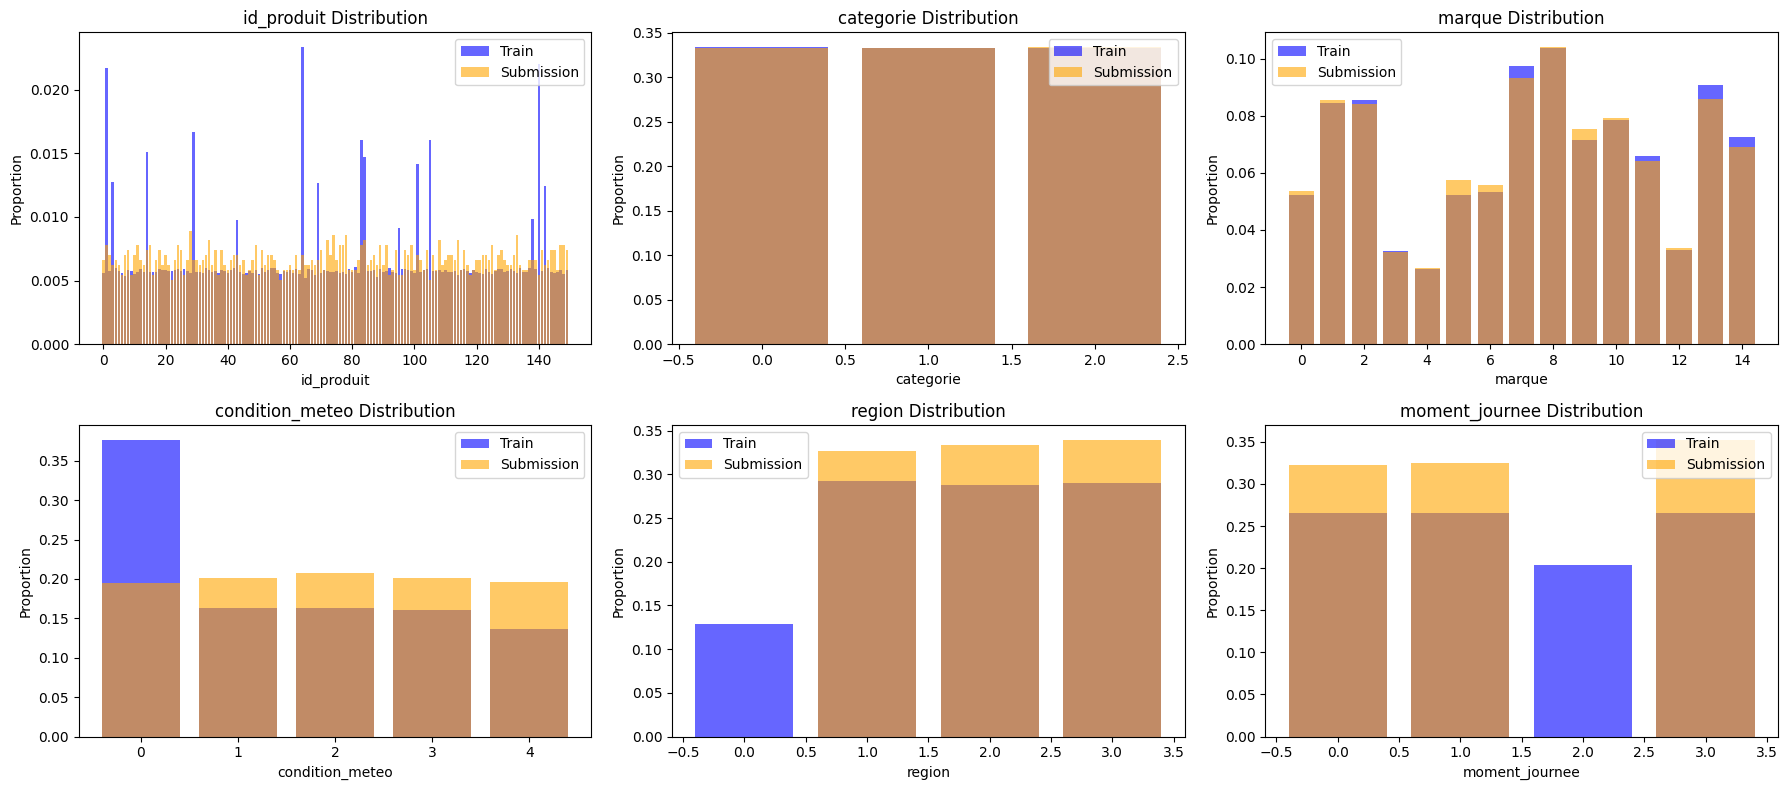

In [ ]:
plot_categorical_distributions(train, submission, categ_cols, n_cols=3)
plot_categorical_distributions(df_all_prep, submission_prep, categ_cols, n_cols=3)

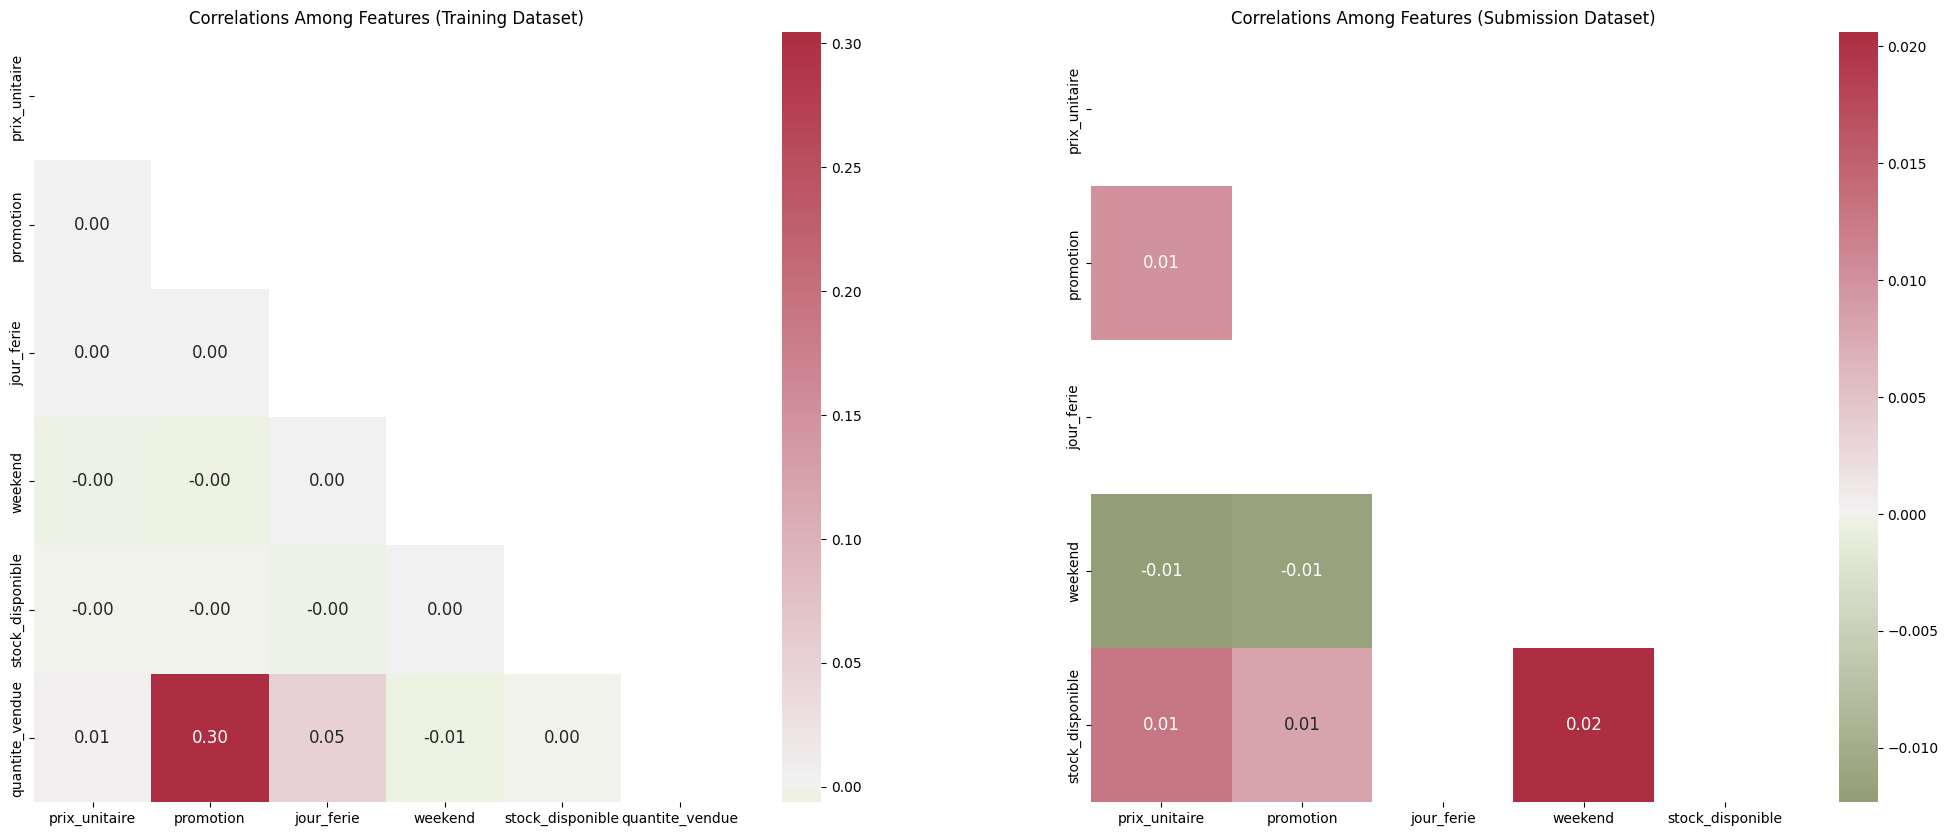

In [ ]:
plot_corr_matrix(train, submission, target, numeric_cols)

## IV. Modélisation

#### Modelisation 1.0

In [ ]:
df_all_prep = df_all_prep.dropna(subset=['quantite_vendue'])

df_all_prep_no_missing = df_all_prep[df_all_prep['has_missing'] == 0]
df_all_prep_missing    = df_all_prep[df_all_prep['has_missing'] == 1]

print(f"Original dataset shape: {df_all_prep.shape}")
print(f"Dataset without missing 'quantite_vendue': {df_all_prep_no_missing.shape}")
print(f"Dataset with missing 'quantite_vendue': {df_all_prep_missing.shape}")

Original dataset shape: (71640, 28)
Dataset without missing 'quantite_vendue': (10923, 28)
Dataset with missing 'quantite_vendue': (60717, 28)


In [ ]:
"""# Separate rows with and without missing 'quantite_vendue' in df_all_prep_missing
missing_target_rows = df_all_prep_missing[df_all_prep_missing['quantite_vendue'].isna()]
known_target_rows = df_all_prep_missing[df_all_prep_missing['quantite_vendue'].notna()]

print(f"Subset with missing 'quantite_vendue' (to predict): {missing_target_rows.shape}")
print(f"Subset with known 'quantite_vendue' (for training): {known_target_rows.shape}")

# Prepare data for the intermediate model
X_intermediate_train = known_target_rows.drop(['quantite_vendue', 'has_missing', 'season'], axis=1)
y_intermediate_train = known_target_rows['quantite_vendue']

X_intermediate_predict = missing_target_rows.drop(['quantite_vendue', 'has_missing', 'season'], axis=1)

# Train the intermediate model
xgb_best_params = {
    'subsample': 0.6,
    'reg_lambda': 0.1,
    'reg_alpha': 0,
    'n_estimators': 100,
    'min_child_weight': 5,
    'max_depth': 3,
    'learning_rate': 0.1,
    'colsample_bytree': 1.0
}

xgb_intermediate = XGBRegressor(
    objective='reg:squarederror',
    **xgb_best_params
)

xgb_intermediate.fit(X_intermediate_train, y_intermediate_train)

# Predict missing 'quantite_vendue' values
predicted_targets = xgb_intermediate.predict(X_intermediate_predict)

# Fill the missing 'quantite_vendue' values
missing_target_rows['quantite_vendue'] = predicted_targets

# Combine the filled missing rows with the known target rows
df_all_prep_missing_filled = pd.concat([known_target_rows, missing_target_rows], axis=0)

# Check final shapes
print(f"Final 'df_all_prep_missing' after filling: {df_all_prep_missing_filled.shape}")
print(f"df_all_prep_no_missing (untouched, for testing): {df_all_prep_no_missing.shape}")"""

'# Separate rows with and without missing \'quantite_vendue\' in df_all_prep_missing\nmissing_target_rows = df_all_prep_missing[df_all_prep_missing[\'quantite_vendue\'].isna()]\nknown_target_rows = df_all_prep_missing[df_all_prep_missing[\'quantite_vendue\'].notna()]\n\nprint(f"Subset with missing \'quantite_vendue\' (to predict): {missing_target_rows.shape}")\nprint(f"Subset with known \'quantite_vendue\' (for training): {known_target_rows.shape}")\n\n# Prepare data for the intermediate model\nX_intermediate_train = known_target_rows.drop([\'quantite_vendue\', \'has_missing\', \'season\'], axis=1)\ny_intermediate_train = known_target_rows[\'quantite_vendue\']\n\nX_intermediate_predict = missing_target_rows.drop([\'quantite_vendue\', \'has_missing\', \'season\'], axis=1)\n\n# Train the intermediate model\nxgb_best_params = {\n    \'subsample\': 0.6,\n    \'reg_lambda\': 0.1,\n    \'reg_alpha\': 0,\n    \'n_estimators\': 100,\n    \'min_child_weight\': 5,\n    \'max_depth\': 3,\n    \'l

In [ ]:
"""# Prepare train and test sets
X_train = df_all_prep_missing_filled.drop(['quantite_vendue', 'has_missing', 'season'], axis=1)
y_train = df_all_prep_missing_filled['quantite_vendue']

X_test = df_all_prep_no_missing.drop(['quantite_vendue', 'has_missing', 'season'], axis=1)
y_test = df_all_prep_no_missing['quantite_vendue']

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape"""

"# Prepare train and test sets\nX_train = df_all_prep_missing_filled.drop(['quantite_vendue', 'has_missing', 'season'], axis=1)\ny_train = df_all_prep_missing_filled['quantite_vendue']\n\nX_test = df_all_prep_no_missing.drop(['quantite_vendue', 'has_missing', 'season'], axis=1)\ny_test = df_all_prep_no_missing['quantite_vendue']\n\nX = pd.concat([X_train, X_test], axis=0)\ny = pd.concat([y_train, y_test], axis=0)\nX_train.shape, y_train.shape, X_test.shape, y_test.shape"

In [ ]:
TARGET = 'quantite_vendue'
COLS_TO_DROP = ['quantite_vendue', 'season', 'has_missing']
X_test, y_test  = df_all_prep_no_missing.drop(COLS_TO_DROP, axis=1), df_all_prep_no_missing[TARGET]
X_train, y_train = df_all_prep_missing.drop(COLS_TO_DROP, axis=1), df_all_prep_missing[TARGET]
submission_prep = submission_prep.drop(COLS_TO_DROP, axis=1, errors='ignore')

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60717, 25), (60717,), (10923, 25), (10923,))

In [ ]:
"""df_all_prep = df_all_prep.dropna(subset=['quantite_vendue'])
X = df_all_prep.drop(['quantite_vendue', 'season'], axis=1)
y = df_all_prep['quantite_vendue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)"""

"df_all_prep = df_all_prep.dropna(subset=['quantite_vendue'])\nX = df_all_prep.drop(['quantite_vendue', 'season'], axis=1)\ny = df_all_prep['quantite_vendue']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)"

r2:  0.1743
MAPE:  0.2527


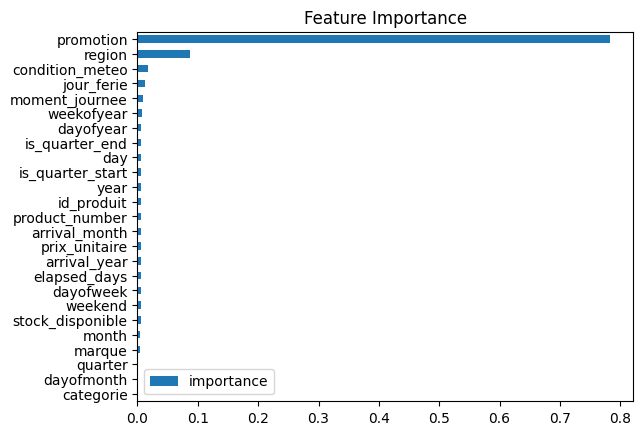

In [ ]:
xgb_best_params = {'subsample': 0.6,
                   'reg_lambda': 0.1,
                   'reg_alpha': 0,
                   'n_estimators': 100,
                   'min_child_weight': 5,
                   'max_depth': 3,
                   'learning_rate': 0.1,
                   'colsample_bytree': 1.0
                   }

xgb = XGBRegressor(
    objective='reg:squarederror',
    **xgb_best_params
)

xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False)

xgb_preds = xgb.predict(X_test)

regression_results(y_true=y_test, y_pred=xgb_preds)

xgb_fi = pd.DataFrame(data=xgb.feature_importances_,
             index=xgb.feature_names_in_,
             columns=['importance'])
xgb_fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()
# MAPE:  0.2415
# 0.2289

r2:  0.175
MAPE:  0.2525


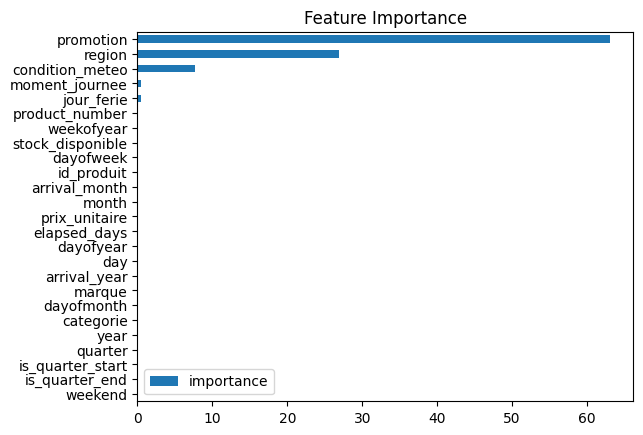

In [ ]:
cat_best_params = {'learning_rate': 0.01,
                   'l2_leaf_reg': 7,
                   'iterations': 1000,
                   'depth': 4,
                   'border_count': 32,
                   'bagging_temperature': 0}

cat = CatBoostRegressor(
    verbose=False,
    **cat_best_params
)

cat.fit(X_train, y_train)

cat_preds = cat.predict(X_test)

regression_results(y_true=y_test, y_pred=cat_preds)

cat_fi = pd.DataFrame(data=cat.feature_importances_,
             index=cat.feature_names_,
             columns=['importance'])
cat_fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()
# MAPE:  0.2384

In [ ]:
rf_best_params = {'n_estimators': 500,
                  'min_samples_split': 10,
                  'min_samples_leaf': 4,
                  'max_features': 'sqrt',
                  'max_depth': None,
                  'bootstrap': True}

rf = RandomForestRegressor(**rf_best_params)

rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)

regression_results(y_true=y_test, y_pred=rf_preds)
# MAPE:  0.2437

r2:  0.1548
MAPE:  0.256


In [ ]:
lgbm_best_params = {'subsample': 1.0,
                    'reg_lambda': 0.0,
                    'reg_alpha': 1.0,
                    'num_leaves': 31,
                    'n_estimators': 100,
                    'min_child_samples': 50,
                    'max_depth': 10,
                    'learning_rate': 0.05,
                    'colsample_bytree': 1.0}

lgbm = LGBMRegressor(n_jobs=-1, verbose=-1,
                     **lgbm_best_params)

lgbm.fit(X_train, y_train)

lgbm_preds = lgbm.predict(X_test)

regression_results(y_true=y_test, y_pred=lgbm_preds)
# MAPE:  0.2388

r2:  0.1742
MAPE:  0.2529


In [ ]:
hist = HistGradientBoostingRegressor()

hist.fit(X_train, y_train)

hist_preds = hist.predict(X_test)

regression_results(y_true=y_test, y_pred=hist_preds)

r2:  0.174
MAPE:  0.2529


In [ ]:
gb = GradientBoostingRegressor()

gb.fit(X_train, y_train)

gb_preds = gb.predict(X_test)

regression_results(y_true=y_test, y_pred=gb_preds)

r2:  0.1752
MAPE:  0.2527


##### Forecast on Test

In [ ]:
def post_process(preds):
     return np.array([int(pred) for pred in preds])

def majority_voting(predictions):
    predictions_array = np.array(predictions)
    majority_votes = mode(predictions_array, axis=0)[0]
    return majority_votes.tolist()

In [ ]:
models = [xgb, cat, rf, lgbm, hist, gb]
all_preds = []
for model in models:
  preds_post_process = post_process(model.predict(X_test))
  all_preds.append(preds_post_process)
  print(f"Model: {model.__class__.__name__}")
  regression_results(y_true=y_test, y_pred=preds_post_process)
  print("="*30)

# MAPE:  0.2344

# Combine predictions into a single list using majority voting
final_predictions = majority_voting(all_preds)
print("Final Predictions:", final_predictions)
regression_results(y_true=y_test, y_pred=final_predictions)
# MAPE:  0.23
# MAPE:  0.2299 manual imputation (mode)
# MAPE:  0.2222 knn imputer

# MAPE:  0.2452
# MAPE:  0.2445

Model: XGBRegressor
r2:  0.1635
MAPE:  0.2452
Model: CatBoostRegressor
r2:  0.1646
MAPE:  0.2456
Model: RandomForestRegressor
r2:  0.1456
MAPE:  0.2476
Model: LGBMRegressor
r2:  0.1636
MAPE:  0.2449
Model: HistGradientBoostingRegressor
r2:  0.164
MAPE:  0.2452
Model: GradientBoostingRegressor
r2:  0.1652
MAPE:  0.2454
Final Predictions: [15, 13, 18, 19, 14, 12, 12, 17, 16, 12, 17, 17, 12, 14, 17, 18, 16, 13, 15, 14, 16, 19, 18, 15, 17, 15, 13, 18, 11, 13, 17, 16, 14, 18, 15, 14, 17, 15, 13, 11, 12, 15, 16, 11, 16, 13, 12, 12, 11, 12, 18, 19, 18, 14, 12, 13, 12, 13, 15, 18, 15, 18, 11, 13, 15, 12, 13, 16, 16, 15, 14, 14, 15, 19, 19, 18, 14, 14, 16, 16, 19, 16, 19, 12, 12, 15, 15, 13, 14, 15, 15, 19, 18, 15, 14, 13, 13, 14, 11, 16, 14, 13, 15, 15, 18, 12, 14, 12, 16, 19, 18, 16, 15, 15, 16, 19, 13, 15, 15, 16, 12, 16, 15, 14, 13, 19, 15, 12, 16, 14, 17, 13, 15, 12, 14, 13, 19, 14, 18, 15, 19, 17, 12, 20, 12, 15, 15, 12, 15, 15, 13, 12, 19, 19, 18, 16, 17, 15, 19, 14, 18, 14, 15, 16, 16, 

In [ ]:
all_preds_raw = np.zeros(X_test.shape[0])

for model in models:
    preds_raw = model.predict(X_test)
    all_preds_raw += preds_raw

    print(f"Model: {model.__class__.__name__}")
    regression_results(y_true=y_test, y_pred=preds_raw)
    print("=" * 30)

all_preds_raw /= len(models)
regression_results(y_true=y_test, y_pred=post_process(all_preds_raw))

Model: XGBRegressor
r2:  0.1743
MAPE:  0.2527
Model: CatBoostRegressor
r2:  0.175
MAPE:  0.2525
Model: RandomForestRegressor
r2:  0.1548
MAPE:  0.256
Model: LGBMRegressor
r2:  0.1742
MAPE:  0.2529
Model: HistGradientBoostingRegressor
r2:  0.174
MAPE:  0.2529
Model: GradientBoostingRegressor
r2:  0.1752
MAPE:  0.2527
r2:  0.1625
MAPE:  0.2453


r2:  0.1682
MAE:  3.0137
RMSE:  3.9113
MAPE:  0.2164

##### Fit on all the train

In [ ]:
# Fit on all the train
for model in models:
  model.fit(X, y)

##### Submission

In [ ]:
# Ensure the columns in submission_prep match the order expected by the model
submission_prep = submission_prep[X_train.columns]

submission_preds = []
for model in models:
  preds_post_process = post_process(model.predict(submission_prep))
  submission_preds.append(preds_post_process)

# Combine predictions into a single list using majority voting
submission_predictions = majority_voting(submission_preds)
#submission_predictions

In [ ]:
submission_df = pd.DataFrame({
    'id': range(1,len(submission_predictions)+1),
    'quantite_vendue': submission_predictions
})

submission_df.to_csv('submission_haitam_preprocessing.csv', index=False)
submission_df.head()

In [ ]:
"""# Look at the worst and best predicted days
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)"""

In [ ]:
import optuna
from optuna.samplers import TPESampler

# Define objective functions for each model
def optimize_xgb(trial, X_train, y_train, X_test, y_test):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 10.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    model = XGBRegressor(objective='reg:squarederror', **params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    preds = model.predict(X_test)
    return mean_absolute_percentage_error(y_test, preds)

def optimize_lgb(trial, X_train, y_train, X_test, y_test):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 10, 300),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }
    model = LGBMRegressor(**params, verbose=-1)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    preds = model.predict(X_test)
    return mean_absolute_percentage_error(y_test, preds)

def optimize_cat(trial, X_train, y_train, X_test, y_test):
    params = {
        'depth': trial.suggest_int('depth', 4, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
    }
    model = CatBoostRegressor(**params, verbose=0)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    preds = model.predict(X_test)
    return mean_absolute_percentage_error(y_test, preds)

def optimize_rf(trial, X_train, y_train, X_test, y_test):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
    }
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_absolute_percentage_error(y_test, preds)

def optimize_hist(trial, X_train, y_train, X_test, y_test):
    params = {
        'max_iter': trial.suggest_int('max_iter', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
    }
    model = HistGradientBoostingRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_absolute_percentage_error(y_test, preds)

def optimize_gb(trial, X_train, y_train, X_test, y_test):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
    }
    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_absolute_percentage_error(y_test, preds)

# List of models and corresponding objective functions
model_objectives = {
    'xgb': optimize_xgb,
    'lgbm': optimize_lgb,
    'cat': optimize_cat,
    'rf': optimize_rf,
    'hist': optimize_hist,
    'gb': optimize_gb,
}

In [ ]:
# Optimize each model
studies = {}
for model_name, objective in model_objectives.items():
    study = optuna.create_study(direction='minimize', sampler=TPESampler())
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=50)
    studies[model_name] = study
    print(f"Best trial for {model_name} found with parameters: {study.best_params} and score: {study.best_value}")

[I 2024-12-18 15:37:16,542] A new study created in memory with name: no-name-efef7bab-d82d-4f1a-a61f-6f87409aa5d9
[I 2024-12-18 15:38:52,726] Trial 0 finished with value: 0.26639507376128846 and parameters: {'learning_rate': 0.0008975658416711551, 'max_depth': 20, 'n_estimators': 420, 'subsample': 0.8091615222902099, 'colsample_bytree': 0.8666326006760954, 'reg_alpha': 0.00018114723119752008, 'reg_lambda': 0.02107432610825219, 'min_child_weight': 6}. Best is trial 0 with value: 0.26639507376128846.
[I 2024-12-18 15:39:15,428] Trial 1 finished with value: 0.2531183838067419 and parameters: {'learning_rate': 0.007527189775830579, 'max_depth': 6, 'n_estimators': 1052, 'subsample': 0.71563836540078, 'colsample_bytree': 0.5904507954105204, 'reg_alpha': 0.39743953398196596, 'reg_lambda': 0.30121012263667973, 'min_child_weight': 3}. Best is trial 1 with value: 0.2531183838067419.
[I 2024-12-18 15:41:25,715] Trial 2 finished with value: 0.2579873752085844 and parameters: {'learning_rate': 0.02

In [ ]:
# Print results
for model_name, study in studies.items():
    print(f"\nModel: {model_name}")
    print("Best Score:", study.best_value)
    print("Best Parameters:", study.best_params)

In [ ]:
stop

### Modélisation 2.0

In [ ]:
# Combine X_train and y_train
train_df_2 = pd.concat([X_train, y_train], axis=1)

# Step 1: Sort the target variable (quantite_vendue) while preserving the original indices
sorted_df = train_df_2[['quantite_vendue']].sort_values(by='quantite_vendue')
print(sorted_df.head())

# Step 2: Divide the sorted DataFrame into bins
#in submission use 10 bins it is better
num_bins = 9
bin_size = len(sorted_df) // num_bins

# Step 2.1: Create bin labels
bin_labels = np.repeat(range(num_bins), bin_size)

# Step 2.2: Handle the remainder and assign remaining values to the last bin
remaining = len(sorted_df) % num_bins
if remaining > 0:
    bin_labels = np.append(bin_labels, np.repeat(num_bins - 1, remaining))

# Step 3: Assign bins to the sorted DataFrame
sorted_df['quantite_vendue_binned'] = bin_labels

# Step 4: Reassign the binned values to the original DataFrame using the original indices
train_df_2['quantite_vendue_binned'] = sorted_df['quantite_vendue_binned']

# Step 5: Verify the distribution of binned target values
print(train_df_2['quantite_vendue_binned'].value_counts())

In [ ]:
# Calculate the mean of 'quantite_vendue' for each bin
bin_means = train_df_2.groupby('quantite_vendue_binned')['quantite_vendue'].mean()
print(bin_means)

In [ ]:
# Create a dictionary to map each bin to its corresponding mean
bin_to_mean_map = dict(enumerate(bin_means))

# Map the binned values to their corresponding mean values
train_df_2['quantite_vendue_mapped'] = train_df_2['quantite_vendue_binned'].map(bin_to_mean_map)

# Display the first 20 rows of the mapped values
print(train_df_2[['quantite_vendue_binned', 'quantite_vendue', 'quantite_vendue_mapped']].head(20))
mean_absolute_percentage_error(train_df_2['quantite_vendue'], train_df_2['quantite_vendue_mapped'])

In [ ]:
gaussian_best_params = {
    'kernel': None,             # RBF kernel by default
    'alpha': 1e-6,              # Reduced noise level
    'optimizer': 'fmin_l_bfgs_b' # Efficient kernel optimization
}

cat_best_params = {
    'depth': 8,                 # Balanced tree depth
    'learning_rate': 0.03,      # Standard CatBoost learning rate
    'iterations': 500,          # Moderate number of boosting rounds
    'l2_leaf_reg': 3.0,         # Regularization strength
    'border_count': 254,        # Default for numeric feature processing
}
xgb_best_params = {
    'bjective':'reg:squarederror',
    'reg_alpha': 0.3,           # Mild L1 regularization
    'reg_lambda': 0.3,          # Stronger L2 regularization
    'gamma': 0.1,               # Minimum loss reduction to split
    'subsample': 0.8,           # Row sampling
    'colsample_bytree': 0.8,    # Feature sampling
    'learning_rate': 0.05,      # Moderate learning rate
    'max_depth': 8,             # Balance depth for interactions
    'n_estimators': 500,        # Reasonable number of iterations
}
hist_best_params = {
    'max_iter': 300,            # Limit iterations for efficiency
    'l2_regularization': 0.1,   # Regularization to avoid overfitting
    'max_leaf_nodes': 31,       # Balanced leaf growth
    'max_bins': 255,            # Default binning
    'early_stopping': True,     # Enable early stopping
    'validation_fraction': 0.2  # Keep more data for training
}
lgb_best_params = {
    'verbose': -1,
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': -1,
    'is_unbalance': True,
}
lasso_best_params = {
    'alpha': 0.2,                # Lower regularization for better flexibility
    'tol': 1e-4,                 # Tolerance for convergence
    'fit_intercept': True,       # Ensure intercept is fit
    'positive': False,           # Allow negative coefficients for more flexibility
    'selection': 'cyclic'        # Efficient selection method
}
gb_best_params = {}

In [ ]:
# Initialize models with best hyperparameters
cat_model = CatBoostRegressor(**cat_best_params, verbose=False)
lasso_model = Lasso(**lasso_best_params)
lgb_model = LGBMRegressor(**lgb_best_params)
hist_model = HistGradientBoostingRegressor(**hist_best_params)
xgb_model = XGBRegressor(**xgb_best_params)
gb_model = GradientBoostingRegressor(**gb_best_params)
elN_model = ElasticNet()
'''cat_class_model = CatBoostClassifier(n_estimators=200, random_state=42, verbose=False)
xgb_class_model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, use_label_encoder=False)
log_reg_model = LogisticRegression(max_iter=150, random_state=42)'''

# To store meta-features and final predictions
meta_features = []
meta_targets = []

cat_features = ['region',
                'promotion',
                'condition_meteo',
                'id_produit',
                'stock_disponible',
                'prix_unitaire',
                'marque']
final_predictions = []

# Cross-validation setup
tscv = TimeSeriesSplit(n_splits=5)
target_encoder = TargetEncoder(cols=['id_produit'], smoothing=10)

i=1
for train_index, val_index in tscv.split(X_train):
    print('fold : ',i)
    i=i+1
    y_train_binned      = train_df_2['quantite_vendue_mapped']
    y_train_true_target = train_df_2['quantite_vendue']
    #y_train_binned_classification = train_df_2['quantite_vendue_binned']

    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_train_true_target , y_fold_val = y_train_binned.iloc[train_index], y_train_true_target.iloc[train_index], y_train_binned.iloc[val_index]
    #y_fold_train_classification, y_fold_val_classification = y_train_binned_classification.iloc[train_index], y_train_binned_classification.iloc[val_index]

    # Target encoding
    X_train_encoded = target_encoder.fit_transform(X_fold_train, y_fold_train_true_target)
    X_val_encoded = target_encoder.transform(X_fold_val)


    # Train each model and collect predictions
    cat_model.fit(X_train_encoded, y_fold_train)
    lasso_model.fit(X_train_encoded, y_fold_train)
    lgb_model.fit(X_train_encoded, y_fold_train)
    hist_model.fit(X_train_encoded, y_fold_train)
    xgb_model.fit(X_train_encoded, y_fold_train)
    gb_model.fit(X_train_encoded, y_fold_train)
    elN_model.fit(X_train_encoded, y_fold_train)


    y_fold_train_mean = y_fold_train.mean()

    # Get predictions for the validation set
    cat_pred = cat_model.predict(X_val_encoded)
    lasso_pred = lasso_model.predict(X_val_encoded)
    lgb_pred = lgb_model.predict(X_val_encoded)
    hist_pred = hist_model.predict(X_val_encoded)
    xgb_pred = xgb_model.predict(X_val_encoded)
    gb_pred = gb_model.predict(X_val_encoded)
    elN_pred = elN_model.predict(X_val_encoded)

    # Stack predictions as meta-features
    meta_features.append(np.vstack([cat_pred, lasso_pred, lgb_pred, hist_pred, xgb_pred, gb_pred, elN_pred]).T)
    meta_targets.append(y_fold_val)

    # For the final ensemble, you can also store predictions on the entire test set if desired.

In [ ]:
# Combine meta-features and targets for meta-model training
meta_features = np.vstack(meta_features)
meta_targets  = np.concatenate(meta_targets)

# Train a meta-model (e.g., Ridge regression)
meta_model_ridge = Ridge(alpha=1.0)
meta_model_ridge.fit(meta_features, meta_targets)

# Train a meta-model: Linear Regression
meta_model_lr = LinearRegression()
meta_model_lr.fit(meta_features, meta_targets)

# Train a meta-model: LAD Regression (Quantile Regressor with quantile=0.5)
meta_model_lad = LADRegression(fit_intercept=True, positive=False)
meta_model_lad.fit(meta_features, meta_targets)

# Evaluate both models
meta_predictions_lr = meta_model_lr.predict(meta_features)
meta_predictions_lad = meta_model_lad.predict(meta_features)
meta_predictions = meta_model_ridge.predict(meta_features)

# Calculate MAPE for each meta-model
mape_meta_lr = mean_absolute_percentage_error(meta_targets, meta_predictions_lr)
mape_meta_lad = mean_absolute_percentage_error(meta_targets, meta_predictions_lad)
mape_meta_ridge = mean_absolute_percentage_error(meta_targets, meta_predictions)

# Print the results
print(f"MAPE of the stacked model (Linear Regression): {mape_meta_lr:.4f}")
print(f"MAPE of the stacked model (LAD Regression): {mape_meta_lad:.4f}")
print(f"MAPE of the meta-model (Ridge Regression): {mape_meta_ridge   :.4f}")

X_test_encoded = target_encoder.transform(X_test)
y_test_mean = y_test.mean()

cat_pred_test = cat_model.predict(X_test_encoded)
lasso_pred_test = lasso_model.predict(X_test_encoded)
lgb_pred_test = lgb_model.predict(X_test_encoded)
hist_pred_test = hist_model.predict(X_test_encoded)
xgb_pred_test = xgb_model.predict(X_test_encoded)
gb_pred_test = gb_model.predict(X_test_encoded)
elN_pred_test = elN_model.predict(X_test_encoded)


# Stack test predictions as meta-features
meta_features_test = np.vstack((
    cat_pred_test,
    lasso_pred_test,
    lgb_pred_test,
    hist_pred_test,
    xgb_pred_test,
    gb_pred_test,
    elN_pred_test,
    #ens_class_pred_test,
    #y_enginner_test,

)).T  # Transpose to match the (n_samples, n_features) shape


meta_predictions_test_lr = meta_model_lr.predict(meta_features_test)
meta_predictions_test_lad = meta_model_lad.predict(meta_features_test)
meta_predictions_test_ridge = meta_model_ridge.predict(meta_features_test)

# Calculate MAPE for each meta-model
mape_meta_lr_test = mean_absolute_percentage_error(y_test, meta_predictions_test_lr)
mape_meta_lad_test = mean_absolute_percentage_error(y_test, meta_predictions_test_lad)
mape_meta_ridge_test = mean_absolute_percentage_error(y_test, meta_predictions_test_ridge)

print(f"MAPE of the stacked model (Linear Regression) test: {mape_meta_lr_test:.4f}")
print(f"MAPE of the stacked model (LAD Regression) test: {mape_meta_lad_test:.4f}")
print(f"MAPE of the meta-model (Ridge Regression) test: {mape_meta_ridge_test   :.4f}")

In [ ]:
y_test_mean = y_test.mean()

# Apply the transformation using apply on the Series
y_lad_predict = pd.Series(meta_predictions_test_lad)
y_lad_predict = y_lad_predict.apply(lambda val: val + 0.7 if val > y_test_mean + 3 else val)

In [ ]:
# Calculate MAPE for each meta-model
from numpy import floor
mape_meta_lr_test = mean_absolute_percentage_error(y_test, floor(meta_predictions_test_lr))
mape_meta_lad_test = mean_absolute_percentage_error(y_test, floor(meta_predictions_test_lad))
mape_meta_ridge_test = mean_absolute_percentage_error(y_test, floor(meta_predictions_test_ridge))
mape_meta_y_lad_predict = mean_absolute_percentage_error(y_test, floor(y_lad_predict))

print(f"MAPE of the stacked model (Linear Regression) test: {mape_meta_lr_test:.6f}")
print(f"MAPE of the stacked model (LAD Regression) test: {mape_meta_lad_test:.6f}")
print(f"MAPE of the meta-model (Ridge Regression) test: {mape_meta_ridge_test   :.6f}")
print(f"MAPE of the meta-model (enginnering) test: {mape_meta_y_lad_predict   :.6f}")

# MAPE of the stacked model (LAD Regression) test: 0.245831

In [ ]:
missing_columns = set(X_train_encoded.columns) - set(submission_prep.columns)

# Step 2: Add missing columns with default values
for col in missing_columns:
    if X_train_encoded[col].dtype == 'bool':
        submission_prep[col] = False  # for boolean columns
    else:
        submission_prep[col] = 0  # for numeric columns (like the ones for quantity)

# Step 3: Reorder the columns in submission_prep to match the order of X_all_encoded
submission_prep = submission_prep[X_train_encoded.columns]

X_test_encoded = target_encoder.transform(submission_prep)

cat_pred_test = cat_model.predict(X_test_encoded)
lasso_pred_test = lasso_model.predict(X_test_encoded)
lgb_pred_test = lgb_model.predict(X_test_encoded)
hist_pred_test = hist_model.predict(X_test_encoded)
xgb_pred_test = xgb_model.predict(X_test_encoded)
gb_pred_test = gb_model.predict(X_test_encoded)
elN_pred_test = elN_model.predict(X_test_encoded)
#gaussian_pred_test = gaussian_model.predict(X_test_encoded)


# Stack test predictions as meta-features
meta_features_test = np.vstack((
    cat_pred_test,
    lasso_pred_test,
    lgb_pred_test,
    hist_pred_test,
    xgb_pred_test,
    gb_pred_test,
    elN_pred_test,
)).T  # Transpose to match the (n_samples, n_features) shape


meta_predictions_test_lr = meta_model_lr.predict(meta_features_test)
meta_predictions_test_lad = meta_model_lad.predict(meta_features_test)
meta_predictions_test_ridge = meta_model_ridge.predict(meta_features_test)

In [ ]:
# Step 3: Use the trained CatBoost model to make predictions
y_sub_pred = floor(meta_predictions_test_lad)

# Step 4: Create a submission DataFrame (if needed)
submission = pd.DataFrame({
    'id': range(1,len(X_test_encoded)+1),  # Assuming you want to keep track of the product ID
    'quantite_vendue': y_sub_pred  # Predicted sales quantity
})

# Step 5: Save the submission file (adjust the filename and format as needed)
submission.to_csv('submission_bins_10_new_features.csv', index=False)
submission.head()

In [ ]:
import optuna
from optuna.samplers import TPESampler

skf = TimeSeriesSplit(n_splits=5)

# Define objective functions for each model
def optimize_xgb(trial, X, Y):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }
    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        model = XGBRegressor(**params, random_state=42)
        model.fit(X_train, Y_train)
        preds = model.predict(X_test)
        scores.append(mean_absolute_percentage_error(Y_test, preds))
    return np.mean(scores)

def optimize_lgb(trial, X, Y):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 10, 300),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }
    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        model = LGBMRegressor(**params, verbose=-1)
        model.fit(X_train, Y_train)
        preds = model.predict(X_test)
        scores.append(mean_absolute_percentage_error(Y_test, preds))
    return np.mean(scores)

def optimize_cat(trial, X, Y):
    params = {
        'depth': trial.suggest_int('depth', 4, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
    }
    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        model = CatBoostRegressor(**params, verbose=0)
        model.fit(X_train, Y_train)
        preds = model.predict(X_test)
        scores.append(mean_absolute_percentage_error(Y_test, preds))
    return np.mean(scores)

def optimize_rf(trial, X, Y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
    }
    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        model = RandomForestRegressor(**params, random_state=42)
        model.fit(X_train, Y_train)
        preds = model.predict(X_test)
        scores.append(mean_absolute_percentage_error(Y_test, preds))
    return np.mean(scores)

def optimize_hist(trial, X, Y):
    params = {
        'max_iter': trial.suggest_int('max_iter', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
    }
    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        model = HistGradientBoostingRegressor(**params)
        model.fit(X_train, Y_train)
        preds = model.predict(X_test)
        scores.append(mean_absolute_percentage_error(Y_test, preds))
    return np.mean(scores)

def optimize_gb(trial, X, Y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
    }
    scores = []
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        model = GradientBoostingRegressor(**params)
        model.fit(X_train, Y_train)
        preds = model.predict(X_test)
        scores.append(mean_absolute_percentage_error(Y_test, preds))
    return np.mean(scores)

# List of models and corresponding objective functions
model_objectives = {
    'xgb': optimize_xgb,
    'lgbm': optimize_lgb,
    'cat': optimize_cat,
    'rf': optimize_rf,
    'hist': optimize_hist,
    'gb': optimize_gb,
}

In [ ]:
# Optimize each model
studies = {}
for model_name, objective in model_objectives.items():
    study = optuna.create_study(direction='minimize', sampler=TPESampler())
    study.optimize(lambda trial: objective(trial, X_train_encoded, y), n_trials=50)
    studies[model_name] = study
    print(f"Best trial for {model_name} found with parameters: {study.best_params} and score: {study.best_value}")

In [ ]:

# Print results
for model_name, study in studies.items():
    print(f"\nModel: {model_name}")
    print("Best Score:", study.best_value)
    print("Best Parameters:", study.best_params)

### Modélisation 2.0

#### Time Series Cross Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5)
df_all_prep = df_all_prep.sort_index()
tss

In [ ]:
"""fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_all_prep):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()"""

#### Train Using Cross Validation¶

In [ ]:
"""tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = []
    TARGET = ''

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)"""

In [ ]:
"""print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')"""

#### Predicting the Future

- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [ ]:
"""# Retrain on all data
df = create_features(df)

FEATURES = []
TARGET = ''

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)"""

In [ ]:
#df.index.max()

In [ ]:
"""# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)"""

In [ ]:
#future_w_features = df_and_future.query('isFuture').copy()

In [ ]:
#future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

In [ ]:
"""future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()"""

### Modélisation 3.0

In [ ]:
"""model1 = XGBRegressor()

def objective1(trial):
    n_train = 0.8

    X_train = train.drop(['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'], axis=1).iloc[:int(n_train*len(train))]
    y_train1 = train['PowerConsumption_Zone1'].iloc[:int(n_train*len(train))]

    X_valid = train.drop(['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'], axis=1).iloc[int(n_train*len(train)):]
    y_valid1 = train['PowerConsumption_Zone1'].iloc[int(n_train*len(train)):]

    # define hyperparameters
    params = {'n_estimators': 279,
             'max_depth': 10,
             'learning_rate': 0.07715487338784907,
             'subsample': 0.9525650873546139,
             'colsample_bytree': 0.9839042155713369,
             'gamma': 0.07748277540970228,
             'reg_alpha': 0.15540822135639026,
             'reg_lambda': 0.4220672374783129
             }

    # train model
    model1.set_params(**params)
    model1.fit(X_train, y_train1)

    # predict on validation set
    preds1 = model1.predict(X_valid)

    # calculate MAE
    mae = mean_absolute_error(y_valid1, preds1)

    return mae"""

In [ ]:
"""# evaluating model using walk-forward validation
def evaluate_model(model, X, y, splits=5):
    n_records = len(X)
    n_train = int(n_records * 0.8)
    n_test = n_records - n_train
    n_splits = splits

    window_size = n_test // n_splits

    print('Number of records: %d' % n_records)
    print('Number of train records: %d' % n_train)
    print('Number of test records: %d' % n_test)
    print('Number of splits: %d' % n_splits)
    mae = []
    predictions = list()
    # walk-forward validation
    for i in range(n_splits):
        # split train and test
        X_train, X_test = X[:n_train+i], X[n_train+i:n_train+i+window_size]
        y_train, y_test = y[:n_train+i], y[n_train+i:n_train+i+window_size]

        # train model
        model.fit(X_train, y_train)

        # predict
        yhat = model.predict(X_test)

        # store prediction
        predictions.append(yhat)

        # calculate MAE
        mae.append(mean_absolute_error(y_test, yhat))
        print('Split: %d, MAE: %.3f' % (i+1, mae[-1]))

    return mae, predictions"""

In [ ]:
"""# evaluate model
mae1, predictions1 = evaluate_model(model1,
                                  train.drop(['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'], axis=1),
                                  train['PowerConsumption_Zone1']
                                )"""

In [ ]:
"""# print average MAE
print('Average MAE: %.3f' % np.mean(mae1))

# train model on full train data
model1.fit(train.drop(['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'], axis=1), train['PowerConsumption_Zone1'])

# predict on test data
test.drop('Datetime', axis=1, inplace=True)
predictions1 = model1.predict(test)"""

In [ ]:
#predictions1

## V. Soumission et Post processing

In [ ]:
#test1 = pd.read_csv('/kaggle/input/EnsiasAIClub-CK/test_data.csv')

In [ ]:
"""# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'Datetime': test1['Datetime'],
                       'predicted_Zone1': predictions1,
                      })


output.to_csv('submission.csv', index=False)
output"""

## VI. Hyperparameters Tuning